# **SIT742: Modern Data Science**

Trimester 2, 2025

Assignment 2

Students:

- Jay Rahul Pawar  (ID s224970276)
- Chudi Onwuakaike (ID s224028935)
- Julio Leon (ID s224504987)

 ***Part I***


## **Question 1.1**

In [ ]:
# Setting up the collab for Spark -
!apt-get -y -qq install openjdk-11-jdk-headless
!pip -q install pyspark==3.5.1 findspark

In [ ]:
''' Findspark is the Python library which helps locate the Apache Spark when
running outside the Spark environment. Without findspark, Python might not
know where exactly Spark is installed.'''

# pyspark is the official Python API for Apache Spark

import os
import findspark, pyspark

findspark.init() # the init method sets up the environment

In [ ]:
from pyspark.sql import SparkSession
# SparkSession is the enrty point for programming with SparkSQL and DataFrames

spark = SparkSession.builder.appName("SIT742Assignment2").getOrCreate()
# The app name is given to monitor the application in Spark UI

spark

In [ ]:
!pip install -q wget

In [ ]:
import zipfile, os, wget

zip_url = 'https://raw.githubusercontent.com/tulip-lab/sit742/refs/heads/develop/Jupyter/data/business_review_submission.zip'
zip_file = wget.download(zip_url)

with zipfile.ZipFile(zip_file, 'r') as zf:
    zf.extractall('/content/data')  # choose folder

os.listdir('/content/data')  # check extracted files



['meta-review-business.csv', 'review.csv']

In [ ]:
# Defining the path to the downloaded files from the github repo.
reviews_path = "data/review.csv"
meta_path = "data/meta-review-business.csv"

# Making two different Dataframes for the data files in the path.
# header -> true will infer that the first row is the header of the csv file.
# inferSchema -> true will tell Spark to guess the data types of the columns.
reviews_df = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .option("multiLine", True)                # reviews can span lines
         .option("quote", '"')                     # default, but explicit
         .option("escape", '"')                    # escape embedded quotes
         .option("ignoreLeadingWhiteSpace", True)
         .option("ignoreTrailingWhiteSpace", True)
         .option("mode", "PERMISSIVE")             # keep bad rows instead of failing
         .option("columnNameOfCorruptRecord", "_corrupt_record")
         .csv(reviews_path)
)

meta_df = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .option("multiLine", True)
         .option("quote", '"')
         .option("escape", '"')
         .option("ignoreLeadingWhiteSpace", True)
         .option("ignoreTrailingWhiteSpace", True)
         .option("mode", "PERMISSIVE")
         .csv(meta_path)
)

In [ ]:
print("Reviews Schema: ")
reviews_df.printSchema()
reviews_df.show(5)

Reviews Schema: 
root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+
|             user_id|             name|         time|rating|                text|pics|resp|             gmap_id|
+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+
|1.091298048426862E20|       Nicki Gore|1566331951619|     5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|    Allen Ratliff|1504917982385|     5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|Jonathan Tringali|1474765901185|     4|We tent camped he...|NULL|NULL|0x56b646ed2220b77...

In [ ]:
print("Meta Schema: ")
meta_df.printSchema()
meta_df.show(5)

Meta Schema: 
root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- num_of_reviews: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)

+--------------------+--------------------+--------------------+-----------+------------------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|             address|             gmap_id|description|          latitude|          long

### **Question 1.1.1**



**Cleaning none or null in text column, changing it to ''No review''.**

In [ ]:
from pyspark.sql.functions import col, sum

# Identifying nulls on each one of the colunms reviews dataset
null_counts_reviews_df = reviews_df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in reviews_df.columns])

print("Number of Null valuess per column in  reviews Dataset \n")
null_counts_reviews_df.show()


# Identifying nulls on each one of the colunms meta_reviews dataset
null_counts_meta_df = meta_df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in meta_df.columns])

print("Number of Null valuess per column in  Meta Dataset \n")
null_counts_meta_df.show()


Number of Null valuess per column in  reviews Dataset 

+-------+----+----+------+------+------+------+-------+
|user_id|name|time|rating|  text|  pics|  resp|gmap_id|
+-------+----+----+------+------+------+------+-------+
|      0|   0|   0|     0|223258|500664|477283|      0|
+-------+----+----+------+------+------+------+-------+

Number of Null valuess per column in  Meta Dataset 

+----+-------+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+
|name|address|gmap_id|description|latitude|longitude|category|avg_rating|num_of_reviews|price|hours|MISC|state|relative_results|url|
+----+-------+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+
|   0|    168|      0|      11258|       0|        0|      62|         0|             0|11189| 4090|3387| 4712|            1808|  0|
+----+-------+-------+-----------+--------+---------+--------+----------+-----

In [ ]:
from pyspark.sql import functions as F

print("Number of Null valuess in  Text column: ")
reviews_df.filter(F.col("text").isNull()).count()

# After the execution, we can see that 'text' column has 223258 NULL values

Number of Null valuess in  Text column: 


223258

In [ ]:
# First 10 records which have the text as NULL
reviews_df.filter(F.col("text").isNull()).show(10, truncate=True)

+--------------------+--------------------+-------------+------+----+----+----+--------------------+
|             user_id|                name|         time|rating|text|pics|resp|             gmap_id|
+--------------------+--------------------+-------------+------+----+----+----+--------------------+
|1.169785198939306E20|          Holly Anne|1629595392534|     4|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.097489809617870...|       Emma Forsberg|1629598102068|     5|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.069279219833724...|       sherry miller|1630540491895|     5|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.176554580456088...|            Amy Lieb|1630292802235|     4|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.069274254664423...|Saralan Ruth Hancock|1590877018198|     4|NULL|NULL|NULL|0x56c8e0455225be8...|
|1.021430901643758...|            AK Woman|1513575394394|     5|NULL|NULL|NULL|0x56c8e0455225be8...|
|1.170856429848184...|         John Herman|1567992031983|     5|NULL|NULL|NULL|0x540c2519bc

In [ ]:
# Now we replace null/None values with 'No review'

reviews_df = reviews_df.withColumn(
    "text",
    F.when(
        (F.col("text").isNull()) | (F.col("text") == F.lit("NULL")), ("No review")
        )
    .otherwise(F.col("text"))
)


In [ ]:
reviews_df.select("text").show(20)
# Column Text sample to check NA values were replaced with No review.

+--------------------+
|                text|
+--------------------+
|We always stay he...|
|Great campground ...|
|We tent camped he...|
|This place is jus...|
|Probably the nice...|
|Great, slept like...|
|It is always a tr...|
|Only 3 booths wit...|
|Not a lot going o...|
|       It's a market|
|           No review|
|           No review|
|           No review|
|           No review|
|Great help, and d...|
|Matt was honest a...|
|Max at Happy Camp...|
|Extremely easy to...|
|Always great serv...|
|Probably the best...|
+--------------------+
only showing top 20 rows



In [ ]:
# Validation to check that all nulls in column Text were replaced.

replaced_na = reviews_df.filter(F.col("text").isNull()).count()
print(f"Remaining nulls in the 'text' to replace: {replaced_na}")


Remaining nulls in the 'text' to replace: 0


### **Question 1.1.2**

**Processing the content in time column**

In [ ]:
### The time is on unix time format miliseconds
reviews_df.select("time").show(5)


+-------------+
|         time|
+-------------+
|1566331951619|
|1504917982385|
|1474765901185|
|1472858535682|
|1529649811341|
+-------------+
only showing top 5 rows



In [ ]:
# Converting Unix time format to yyyy-mm-dd in a new colunm 'newtime'
reviews_df = reviews_df.withColumn(
    "newtime",
    F.from_unixtime((F.col("time")/1000).cast("long"), "yyyy-MM-dd")
)

# Comparison between unix time format and yyyy-mm-dd format
reviews_df.select("time", "newtime").show(5, truncate=False)

+-------------+----------+
|time         |newtime   |
+-------------+----------+
|1566331951619|2019-08-20|
|1504917982385|2017-09-09|
|1474765901185|2016-09-25|
|1472858535682|2016-09-02|
|1529649811341|2018-06-22|
+-------------+----------+
only showing top 5 rows



As we can see in the output, the time is stored as Unix timestamp in miliseconds. Hence, that needs to be first ceonverted to seconds and then format.

In [ ]:
reviews_df.show(5)

+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+----------+
|             user_id|             name|         time|rating|                text|pics|resp|             gmap_id|   newtime|
+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+----------+
|1.091298048426862E20|       Nicki Gore|1566331951619|     5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|2019-08-20|
|1.132409264057589...|    Allen Ratliff|1504917982385|     5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|2017-09-09|
|1.130448378911412...|Jonathan Tringali|1474765901185|     4|We tent camped he...|NULL|NULL|0x56b646ed2220b77...|2016-09-25|
|1.103291551475920...|           S Blad|1472858535682|     4|This place is jus...|NULL|NULL|0x56b646ed2220b77...|2016-09-02|
| 1.08989634908602E20|   Daniel Formoso|1529649811341|     5|Probably the nice...|NULL|NULL|0x56b646ed2220b77...|2018-06-22|


## **Question 1.2**

### **Question 1.2.1**

**Using pyspark to calculate the number of reviews per each unique gmap_id**

In [ ]:
# Showing a sample of gmap_id
reviews_df.select("gmap_id").show(5)

+--------------------+
|             gmap_id|
+--------------------+
|0x56b646ed2220b77...|
|0x56b646ed2220b77...|
|0x56b646ed2220b77...|
|0x56b646ed2220b77...|
|0x56b646ed2220b77...|
+--------------------+
only showing top 5 rows



In [ ]:
# Checking for null values
reviews_df.filter(F.col("gmap_id").isNull()).count()

0

There are zero rows with NULL gmap_id in reviews_df. That's good for us as we don't have to modify any records


In [ ]:
# Calculating  number of reviews per each unique gmap_id
reviews_per_gmap = (
    reviews_df
    .groupBy("gmap_id")
    .agg(F.count("*").cast("float").alias("total_per_gmap_id"))
    .orderBy(F.col("total_per_gmap_id").desc())
)

In [ ]:
# Counting reviews per gmap_id and showing top five rows
reviews_per_gmap.show(5, truncate = False)

reviews_per_gmap.printSchema()

+-------------------------------------+-----------------+
|gmap_id                              |total_per_gmap_id|
+-------------------------------------+-----------------+
|0x56c897b9ce6000df:0xd707e127588a8c6c|2833.0           |
|0x56c899d058920487:0x12882cc9133f2f54|2594.0           |
|0x56c897c63697ee39:0x419904ababbc740b|2258.0           |
|0x56c8965ee2fb87a1:0x559736347bd48842|2237.0           |
|0x56c89629bde7481f:0x7e8a9413ab25d5d |2219.0           |
+-------------------------------------+-----------------+
only showing top 5 rows

root
 |-- gmap_id: string (nullable = true)
 |-- total_per_gmap_id: float (nullable = false)



### **Question 1.2.2**

**Transforming the current pyspark dataframe to pandas dataframe**

In [ ]:
import pandas as pd

# Transforming PySpark dataframe to Pandas dataframe
df = reviews_df.toPandas()


In [ ]:
# Converting time which is in milliseconds to a datetime

df["time"] = pd.to_numeric(df["time"], errors="coerce")
df["time"] = pd.to_datetime(df["time"], unit="ms", errors="coerce")

print(df["time"].head())
print(df["time"].dtype)

0   2019-08-20 20:12:31.619
1   2017-09-09 00:46:22.385
2   2016-09-25 01:11:41.185
3   2016-09-02 23:22:15.682
4   2018-06-22 06:43:31.341
Name: time, dtype: datetime64[ns]
datetime64[ns]


In [ ]:
# review_time column extract hour from datetime
df["review_time"] = df["time"].dt.strftime("%H:00") # extract hour

# Show first 5 rows
df.head(5)


user_id               name                    time  rating  \
0  1.091298e+20         Nicki Gore 2019-08-20 20:12:31.619       5   
1  1.132409e+20      Allen Ratliff 2017-09-09 00:46:22.385       5   
2  1.130448e+20  Jonathan Tringali 2016-09-25 01:11:41.185       4   
3  1.103292e+20             S Blad 2016-09-02 23:22:15.682       4   
4  1.089896e+20     Daniel Formoso 2018-06-22 06:43:31.341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id     newtime review_time  
0  0x56b646ed2220b77f:0xd8975e316de80952  2019-08-20       20:00  
1  0x56b646ed2220b77f:0xd8975e316de80952  2017-09-09       00:00  
2  0x56b646ed2220b77f:0xd8975e316de80952  2016-09-25       01:00  
3  0x56b646ed2220b77f:0xd8975e316de80952  2016-09-02       23:00  
4  0x56b646ed2220b77f:0xd8975e316de80952  2018-06-22       06:00

Printing pandas dataframe with top 5 rows after creating the column review_time which now is showing absolute time values.

In [ ]:
df['review_time'] # hour level information

0         20:00
1         00:00
2         01:00
3         23:00
4         06:00
          ...  
521510    00:00
521511    01:00
521512    04:00
521513    19:00
521514    15:00
Name: review_time, Length: 521515, dtype: object

### **Question 1.2.3**

**Using matplotlib for visualizations on the relationship between gmap_id and reivew_time.**

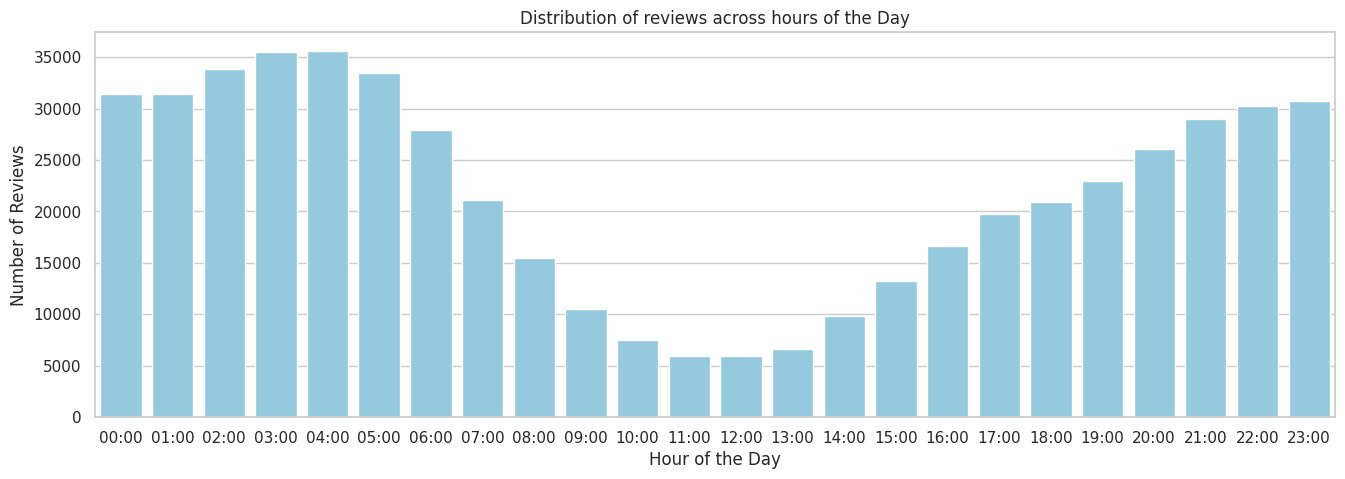

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'whitegrid')

# This part creates an ordered list of all hours formatted as 00:00–23:00
hour_order = [f"{h:02d}:00" for h in range(24)]

# Distribution of reviews across hours of day
plt.figure(figsize = (16, 5))

sns.countplot(x = 'review_time', data = df, color = 'skyblue',order=hour_order)
plt.title("Distribution of reviews across hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Reviews")
plt.show()


**Review distribution over the day**

The barchart shows that most reviews are concentrated during late night and early morning hours (0–6h).

After 7 AM, there is a decline, with the lowest activity between 10 AM and 1 PM.

Reviews increase again from the afternoon (16h), peaking in the evening (20–23h).

Very few reviews are posted around midday, suggesting that people are less likely to leave reviews during work or active business hours.

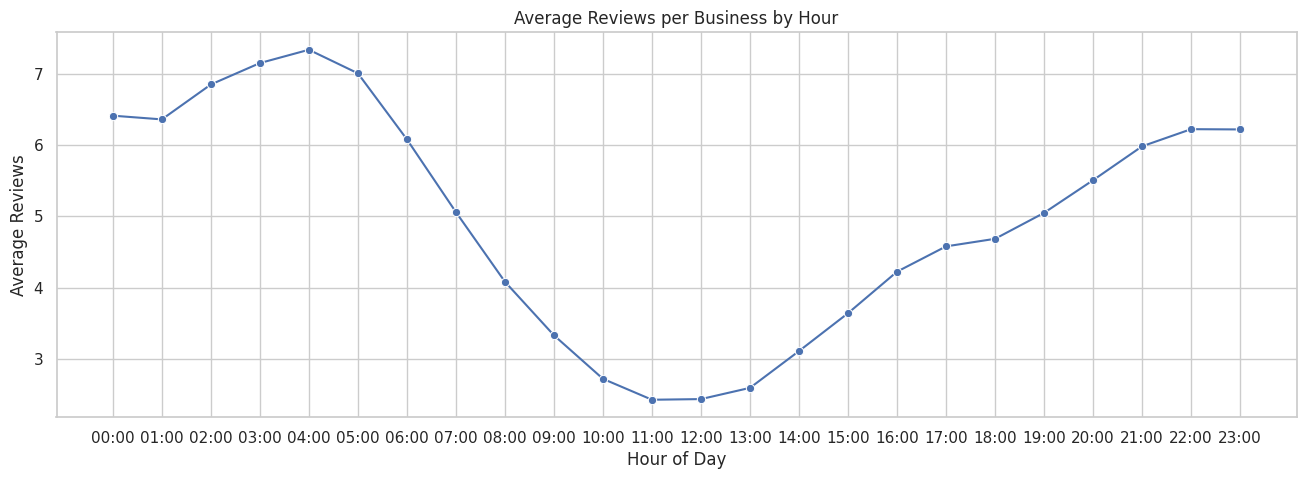

In [ ]:
# Reviews per business at different times
reviews_by_time = df.groupby(["review_time", "gmap_id"]).size().reset_index(name="count")
avg_reviews = reviews_by_time.groupby("review_time")["count"].mean().reset_index()

plt.figure(figsize=(16,5))
sns.lineplot(x="review_time", y="count", data=avg_reviews, marker="o")
plt.title("Average Reviews per Business by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Reviews")
plt.show()

**Average reviews per business by hour**

The second chart shows that businesses receive more reviews late at night (2–5h), where the average is over 7 reviews per business.

The lowest averages is around 10–12h, where businesses average fewer than 3 reviews per business.

Evening hours (18–22h) again show a rise in review activity, aligning with when customers finish shopping, dining, or other services.

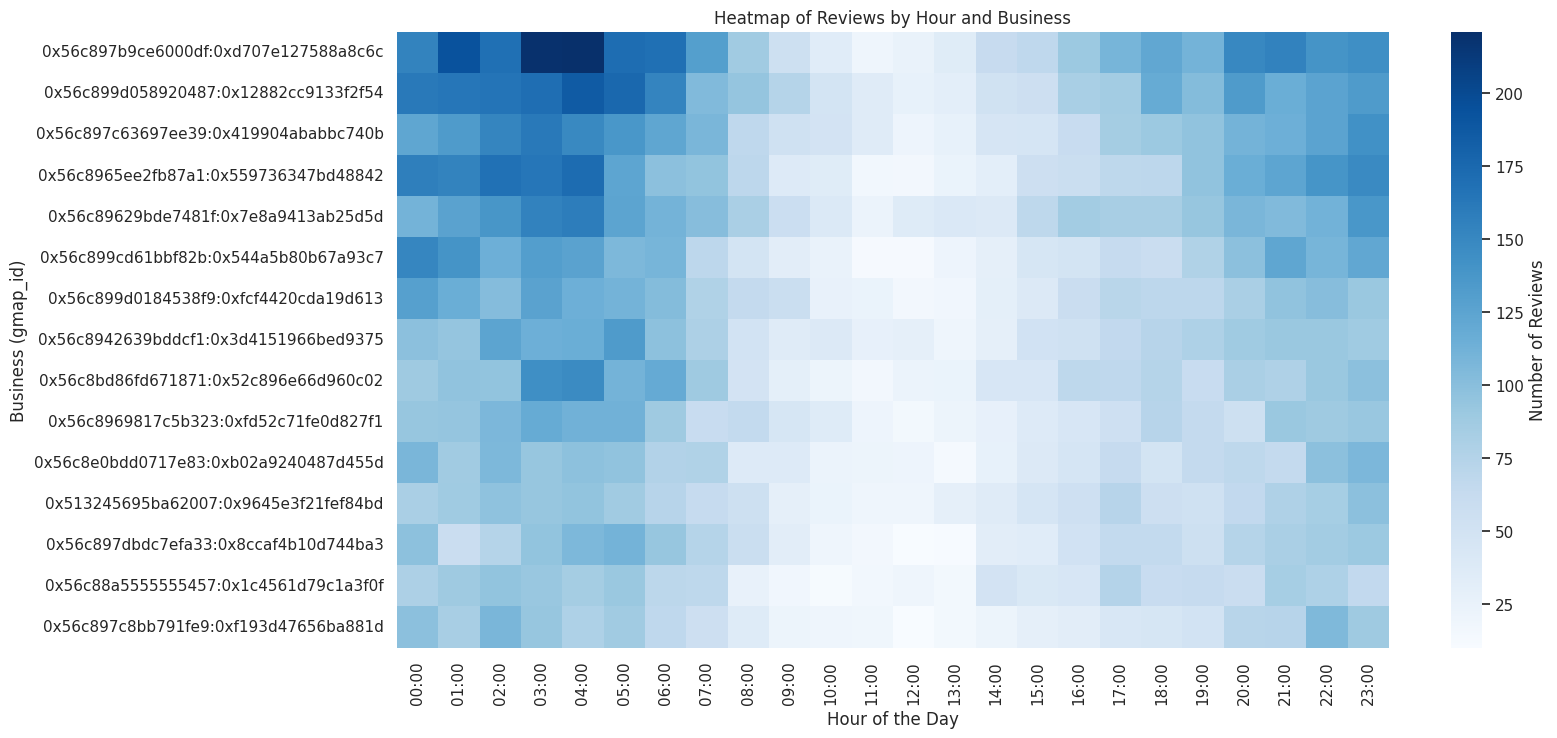

In [ ]:
pivot_table = reviews_by_time.pivot(index="gmap_id", columns="review_time", values="count").fillna(0)

# Calculate total reviews per business across all hours
total_reviews = pivot_table.sum(axis=1)

# Select top 15 businesses by total review count
top_15_businesses = total_reviews.nlargest(15).index

# Filter the pivot table to include only these top businesses
pivot_table_top15 = pivot_table.loc[top_15_businesses]


plt.figure(figsize=(16, 8))
sns.heatmap(pivot_table_top15, cmap="Blues", cbar_kws={'label': 'Number of Reviews'})
plt.title("Heatmap of Reviews by Hour and Business")
plt.xlabel("Hour of the Day")
plt.ylabel("Business (gmap_id)")
plt.show()

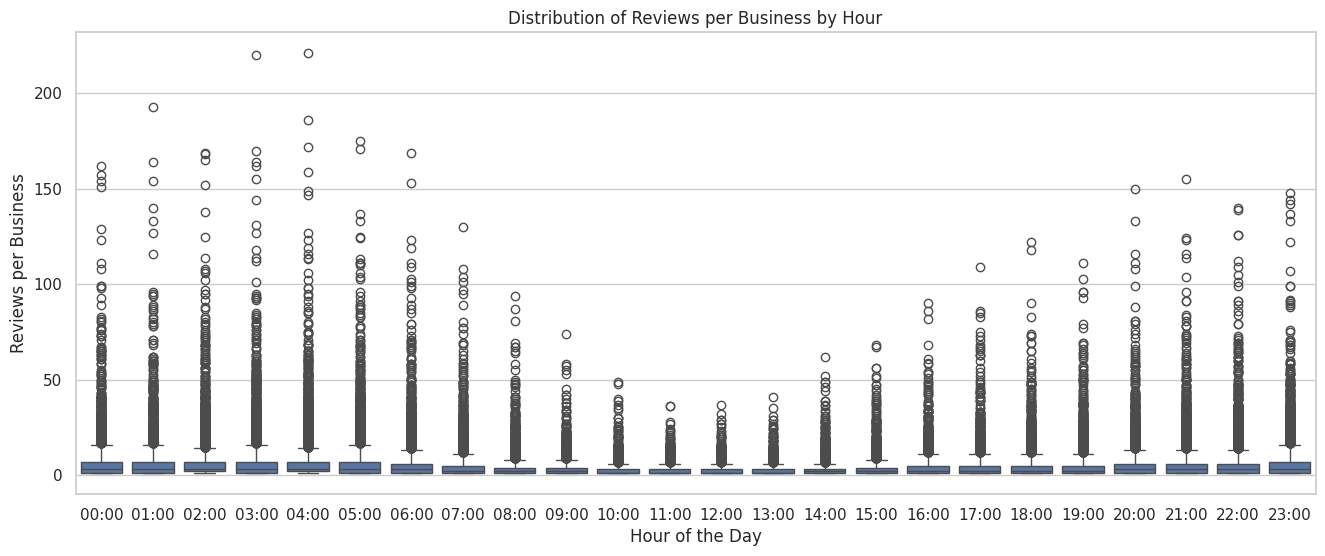

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="review_time", y="count", data=reviews_by_time, order=hour_order)
plt.title("Distribution of Reviews per Business by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Reviews per Business")
plt.show()


## **Question 1.3**

### **Question 1.3.1**

**Determining which workday (day of the week), generates the most reviews**

In [ ]:
# Firstly, converting the meta_df to Pandas
meta_pd = meta_df.toPandas()

# checking colunm names for both datasets
print(list(meta_pd.columns))

['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']


In [ ]:
print(list(df.columns))

['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'newtime', 'review_time']


In [ ]:
# Before joining the dataset, it is necessary to rename the column 'name' to avoid errors.
df_renamed= df.rename(columns={'name': 'reviewer_name'})
meta_pd= meta_pd.rename(columns={'name': 'business_name'})

# Now that the reviews dataset and the metadata are aligned, we’ve
# joined them using the gmap_id column, which serves as the common key between both datasets.

merged_df = pd.merge(df_renamed, meta_pd, on='gmap_id', how='left')



In [ ]:
merged_df.columns

Index(['user_id', 'reviewer_name', 'time', 'rating', 'text', 'pics', 'resp',
       'gmap_id', 'newtime', 'review_time', 'business_name', 'address',
       'description', 'latitude', 'longitude', 'category', 'avg_rating',
       'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results',
       'url'],
      dtype='object')

In [ ]:
# A new column has been added to extract the weekday corresponding to each business rating.
merged_df['Weekday'] = merged_df['time'].dt.day_name()

merged_df.columns

Index(['user_id', 'reviewer_name', 'time', 'rating', 'text', 'pics', 'resp',
       'gmap_id', 'newtime', 'review_time', 'business_name', 'address',
       'description', 'latitude', 'longitude', 'category', 'avg_rating',
       'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results',
       'url', 'Weekday'],
      dtype='object')

In [ ]:
# Here we use group by to ideentify how man reviews per day  Grouping by Weekday
reviews_by_day = (
    merged_df.groupby('Weekday')
    .size()
    .reset_index(name = 'review_count')
)

reviews_by_day

Weekday  review_count
0     Friday         71673
1     Monday         72293
2   Saturday         77939
3     Sunday         80339
4   Thursday         73375
5    Tuesday         72503
6  Wednesday         73875

In [ ]:
# Ordering the reviews_by_day by real days of the week

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
reviews_by_day['Weekday'] = pd.Categorical(reviews_by_day['Weekday'], categories = weekday_order)
reviews_by_day = reviews_by_day.sort_values('Weekday')

reviews_by_day

Weekday  review_count
1     Monday         72293
5    Tuesday         72503
6  Wednesday         73875
4   Thursday         73375
0     Friday         71673
2   Saturday         77939
3     Sunday         80339

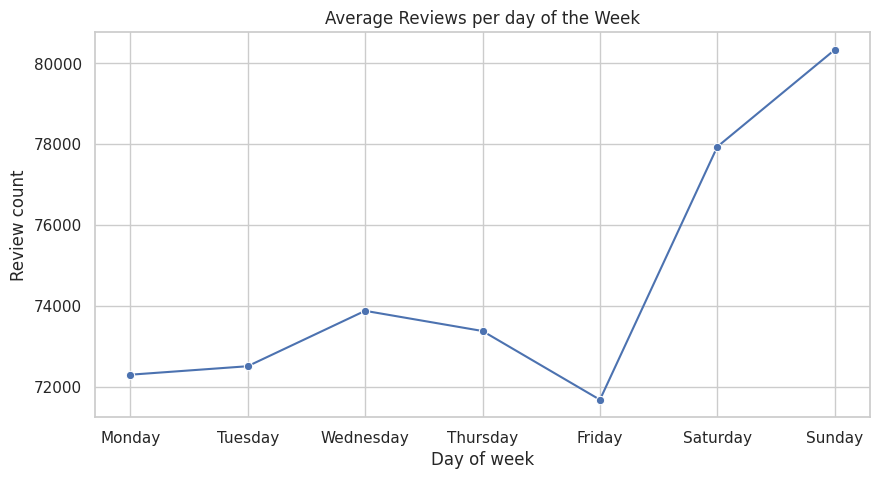

In [ ]:
# Plotting the line plot for the days of the week on the X-axis and number of
# reviews on the Y axis

plt.figure(figsize = (10, 5))
sns.lineplot(x = "Weekday", y = 'review_count', data = reviews_by_day, marker = 'o')
plt.title("Average Reviews per day of the Week")
plt.xlabel("Day of week")
plt.ylabel("Review count")
plt.grid(True)
plt.show()

The line graph shows that people are significantly more active with reviews on the weekend—Sunday tops the chart with over 80,000 reviews, followed closely by Saturday. During the week, Wednesday and Thursday have the most action, while Monday, Tuesday, and especially Friday lag are behind.

### **Question 1.3.2**

**Identifying the name of the business that has the highest average ratings on the day with most reviews**

In [ ]:
# Using idmax to get the maximun value in column review_count

best_day = reviews_by_day.loc[reviews_by_day['review_count'].idxmax(), 'Weekday']
best_day

'Sunday'

In [ ]:
# Filter reviews for top day
df_best_day = merged_df[merged_df['Weekday'] == best_day]

df_best_day.head()

user_id      reviewer_name                    time  rating  \
4   1.130448e+20  Jonathan Tringali 2016-09-25 01:11:41.185       4   
5   1.130448e+20  Jonathan Tringali 2016-09-25 01:11:41.185       4   
12  1.163932e+20             Matt H 2021-07-04 03:27:50.215       5   
13  1.163932e+20             Matt H 2021-07-04 03:27:50.215       5   
20  1.169785e+20         Holly Anne 2021-08-22 01:23:12.534       4   

                                                 text  \
4   We tent camped here for 2 nights while explori...   
5   We tent camped here for 2 nights while explori...   
12  It is always a treat to visit this rain or shi...   
13  It is always a treat to visit this rain or shi...   
20                                          No review   

                                                 pics  resp  \
4                                                None  None   
5                                                None  None   
12  [{'url': ['https://lh5.googleusercontent.com/p...  None   
13  [{'url': ['https://lh5.googleusercontent.com/p...  None   
20                                               None  None   

                                  gmap_id     newtime review_time  ...  \
4   0x56b646ed2220b77f:0xd8975e316de80952  2016-09-25       01:00  ...   
5   0x56b646ed2220b77f:0xd8975e316de80952  2016-09-25       01:00  ...   
12  0x56c8992b5dee7225:0x9f7f4bf151868cf7  2021-07-04       03:00  ...   
13  0x56c8992b5dee7225:0x9f7f4bf151868cf7  2021-07-04       03:00  ...   
20  0x56c8992b5dee7225:0x9f7f4bf151868cf7  2021-08-22       01:00  ...   

                                            category avg_rating  \
4   ['RV park', 'Cabin rental agency', 'Campground']        4.5   
5   ['RV park', 'Cabin rental agency', 'Campground']        4.5   
12                               ["Farmers' market"]        4.2   
13                               ["Farmers' market"]        4.2   
20                               ["Farmers' market"]        4.2   

   num_of_reviews  price                                              hours  \
4              18   None                                               None   
5              18   None                                               None   
12             18   None  [['Thursday', 'Closed'], ['Friday', '10AM–5PM'...   
13             18   None  [['Thursday', 'Closed'], ['Friday', '10AM–5PM'...   
20             18   None  [['Thursday', 'Closed'], ['Friday', '10AM–5PM'...   

                                                 MISC  \
4                                                None   
5                                                None   
12  {'Service options': ['In-store shopping'], 'Ac...   
13  {'Service options': ['In-store shopping'], 'Ac...   
20  {'Service options': ['In-store shopping'], 'Ac...   

                      state  \
4                      None   
5                      None   
12  Closed ⋅ Opens 10AM Fri   
13  Closed ⋅ Opens 10AM Fri   
20  Closed ⋅ Opens 10AM Fri   

                                     relative_results  \
4   ['0x56b6445fd9f9e387:0x6dd3d374ef56431a', '0x5...   
5   ['0x56b6445fd9f9e387:0x6dd3d374ef56431a', '0x5...   
12                                               None   
13                                               None   
20                                               None   

                                                  url Weekday  
4   https://www.google.com/maps/place//data=!4m2!3...  Sunday  
5   https://www.google.com/maps/place//data=!4m2!3...  Sunday  
12  https://www.google.com/maps/place//data=!4m2!3...  Sunday  
13  https://www.google.com/maps/place//data=!4m2!3...  Sunday  
20  https://www.google.com/maps/place//data=!4m2!3...  Sunday  

[5 rows x 25 columns]

In [ ]:
# Average rating per business (gmap_id)
avg_rating_per_bitz = (
    df_best_day.groupby(["gmap_id", "business_name", "category"])
    .agg(
        average_rating = ("rating", "mean"),
        review_count = ("rating", "count")
    )
)

avg_rating_per_bitz = avg_rating_per_bitz.sort_values(
    by=["average_rating", "review_count"],
    ascending=[False, False]
).reset_index()

'''The operation groupby(['gmap_id', 'business_name', 'category']) tells pandas
to identify unique combinations of these three fields.
For each unique group of (gmap_id, business_name, category), it collects all
corresponding rows together.
The .mean() function then computes the average of the rating column for each
group. This summarizes ratings at the granularity defined by the three keys.'''

avg_rating_per_bitz.head(10)


gmap_id  \
0  0x56c89869bfea62e3:0xf8778ab6f95058b5   
1   0x56c8e8d80099933b:0xe713b933ea9ad13   
2   0x56c864be40274793:0xafe08d3ac6f4d5d   
3  0x56c897c931af014b:0x7ce8d189db1c8a1b   
4  0x56c8e27781137c49:0x1a7d7c5b7d55628d   
5  0x56c663ee84279121:0x37657b5a91a696ec   
6  0x56c67c9ee8c294af:0x5ccab006ce0db3f6   
7  0x56c80c67ad848299:0x95b9aeb0da99ad5c   
8  0x56c896283268dc03:0x25aebb4d6fbb540b   
9  0x56c89760c494bc1d:0x6a9dc3c011983c13   

                                       business_name  \
0                             Anchorage Ace Hardware   
1                                   Escape Anchorage   
2  Winner Creek Gorge Trail Head (Lower Winner Cr...   
3                           Alaska Veterinary Clinic   
4                             Bleeding Heart Brewery   
5                                Lucky Raven Tobacco   
6                          Kenai Veterinary Hospital   
7                    Varly's Swiftwater Seafood Cafe   
8  Midnight Market | Vape And Smoke Shop In Ancho...   
9                      Alaska Axe Co. - Axe Throwing   

                                            category  average_rating  \
0  ['Hardware store', 'Home improvement store', '...             5.0   
1              ['Escape room center', 'Entertainer']             5.0   
2              ['Hiking area', 'Tourist attraction']             5.0   
3            ['Veterinarian', 'Veterinary pharmacy']             5.0   
4                                        ['Brewery']             5.0   
5                                   ['Tobacco shop']             5.0   
6                ['Animal hospital', 'Veterinarian']             5.0   
7              ['Seafood restaurant', 'Bar', 'Cafe']             5.0   
8  ['Vaporizer store', 'Cigar shop', 'Hookah stor...             5.0   
9  ['Sports club', 'Corporate entertainment servi...             5.0   

   review_count  
0            16  
1            16  
2            15  
3            13  
4            13  
5            12  
6            11  
7            11  
8            11  
9            11

In [ ]:
best_business = avg_rating_per_bitz.head(1)   # take only the top 1

best_business

gmap_id           business_name  \
0  0x56c89869bfea62e3:0xf8778ab6f95058b5  Anchorage Ace Hardware   

                                            category  average_rating  \
0  ['Hardware store', 'Home improvement store', '...             5.0   

   review_count  
0            16

Since multiple businesses had an average rating of 5, it was necessary also consider the total number of reviews. However, for a more accurate comparison, it may be important to strike a balance between the number of reviews and the final score, as a higher volume of reviews generally provides a more reliable measure of quality.

### **Question 1.3.3**

**Finding out insights such as which category it is and what are the peak hours**

In [ ]:
best_business_nm = avg_rating_per_bitz.iloc[0]["business_name"]
top_category = merged_df.loc[merged_df["business_name"] == best_business_nm, "category"].mode().iat[0]

top_category

"['Hardware store', 'Home improvement store', 'Paint store', 'Tool store']"

In [ ]:
top_cat_df = merged_df[merged_df['category'] == top_category].copy()

print("Top category:", top_category)


Top category: ['Hardware store', 'Home improvement store', 'Paint store', 'Tool store']


In [ ]:
top_cat_df.columns

Index(['user_id', 'reviewer_name', 'time', 'rating', 'text', 'pics', 'resp',
       'gmap_id', 'newtime', 'review_time', 'business_name', 'address',
       'description', 'latitude', 'longitude', 'category', 'avg_rating',
       'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results',
       'url', 'Weekday'],
      dtype='object')

In [ ]:
reviews_by_hour = (
    top_cat_df.groupby('review_time')
    .size()
    .reset_index(name = 'review_count')
)

reviews_by_hour

review_time  review_count
0        00:00            22
1        01:00            20
2        02:00            24
3        03:00            23
4        04:00            25
5        05:00            18
6        06:00            13
7        07:00             4
8        08:00             8
9        09:00             5
10       10:00             3
11       11:00             2
12       12:00             2
13       13:00             2
14       14:00             4
15       15:00             5
16       16:00            11
17       17:00             8
18       18:00            14
19       19:00            16
20       20:00            21
21       21:00            14
22       22:00            20
23       23:00            19

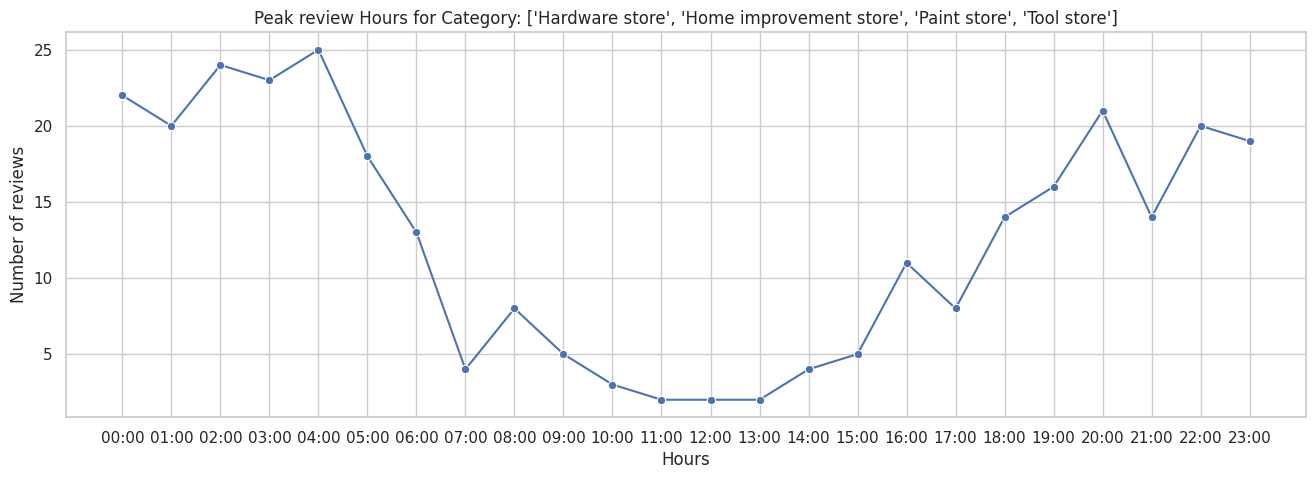

In [ ]:
plt.figure(figsize = (16, 5))
sns.lineplot(x = 'review_time',
             y = 'review_count',
             data = reviews_by_hour,
             marker = 'o')
plt.title(f"Peak review Hours for Category: {top_category}")
plt.xlabel("Hours")
plt.ylabel("Number of reviews")
plt.grid(True)
plt.show()

Hence, from the lineplot, we can see that the peak hour for review is around 4 a.m and the number of reviews for category ['Hardware store', 'Home improvement store', 'Paint store', 'Tool store'] (which is the top category) is more than 25.

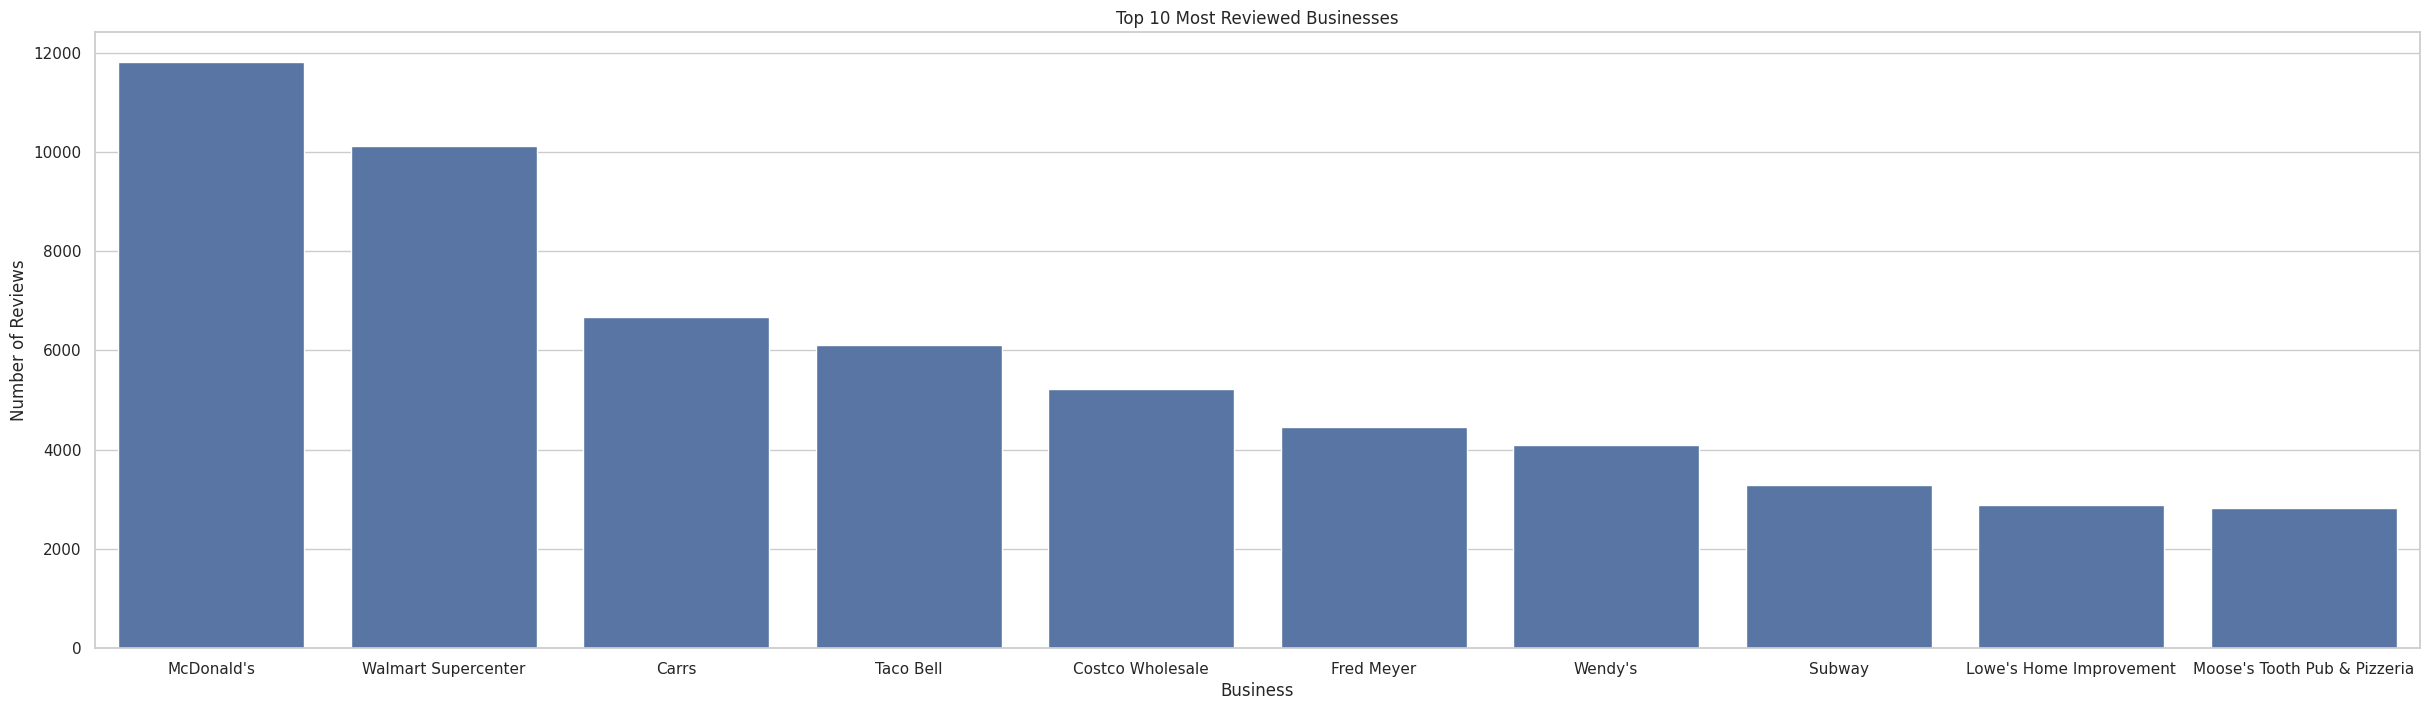

In [ ]:
# Top 10 most reviewed businesses
reviews_by_biz = (
    merged_df.groupby(['business_name', 'category'])
    .size()
    .reset_index(name = 'review_count')
    .sort_values('review_count', ascending = False)
    .head(10)
)

plt.figure(figsize = (30, 8))
sns.barplot(data = reviews_by_biz,
            x = 'business_name',
            y = 'review_count'
            )
plt.title("Top 10 Most Reviewed Businesses")
plt.xlabel("Business")
plt.ylabel("Number of Reviews")
plt.show()

The bar graph shows that McDonald's has the highest number of reviews overall. However, to determine which business is actually the best, further data analysis is needed this graph doesn’t distinguish between positive and negative reviews, so volume alone doesn’t tell the full story.

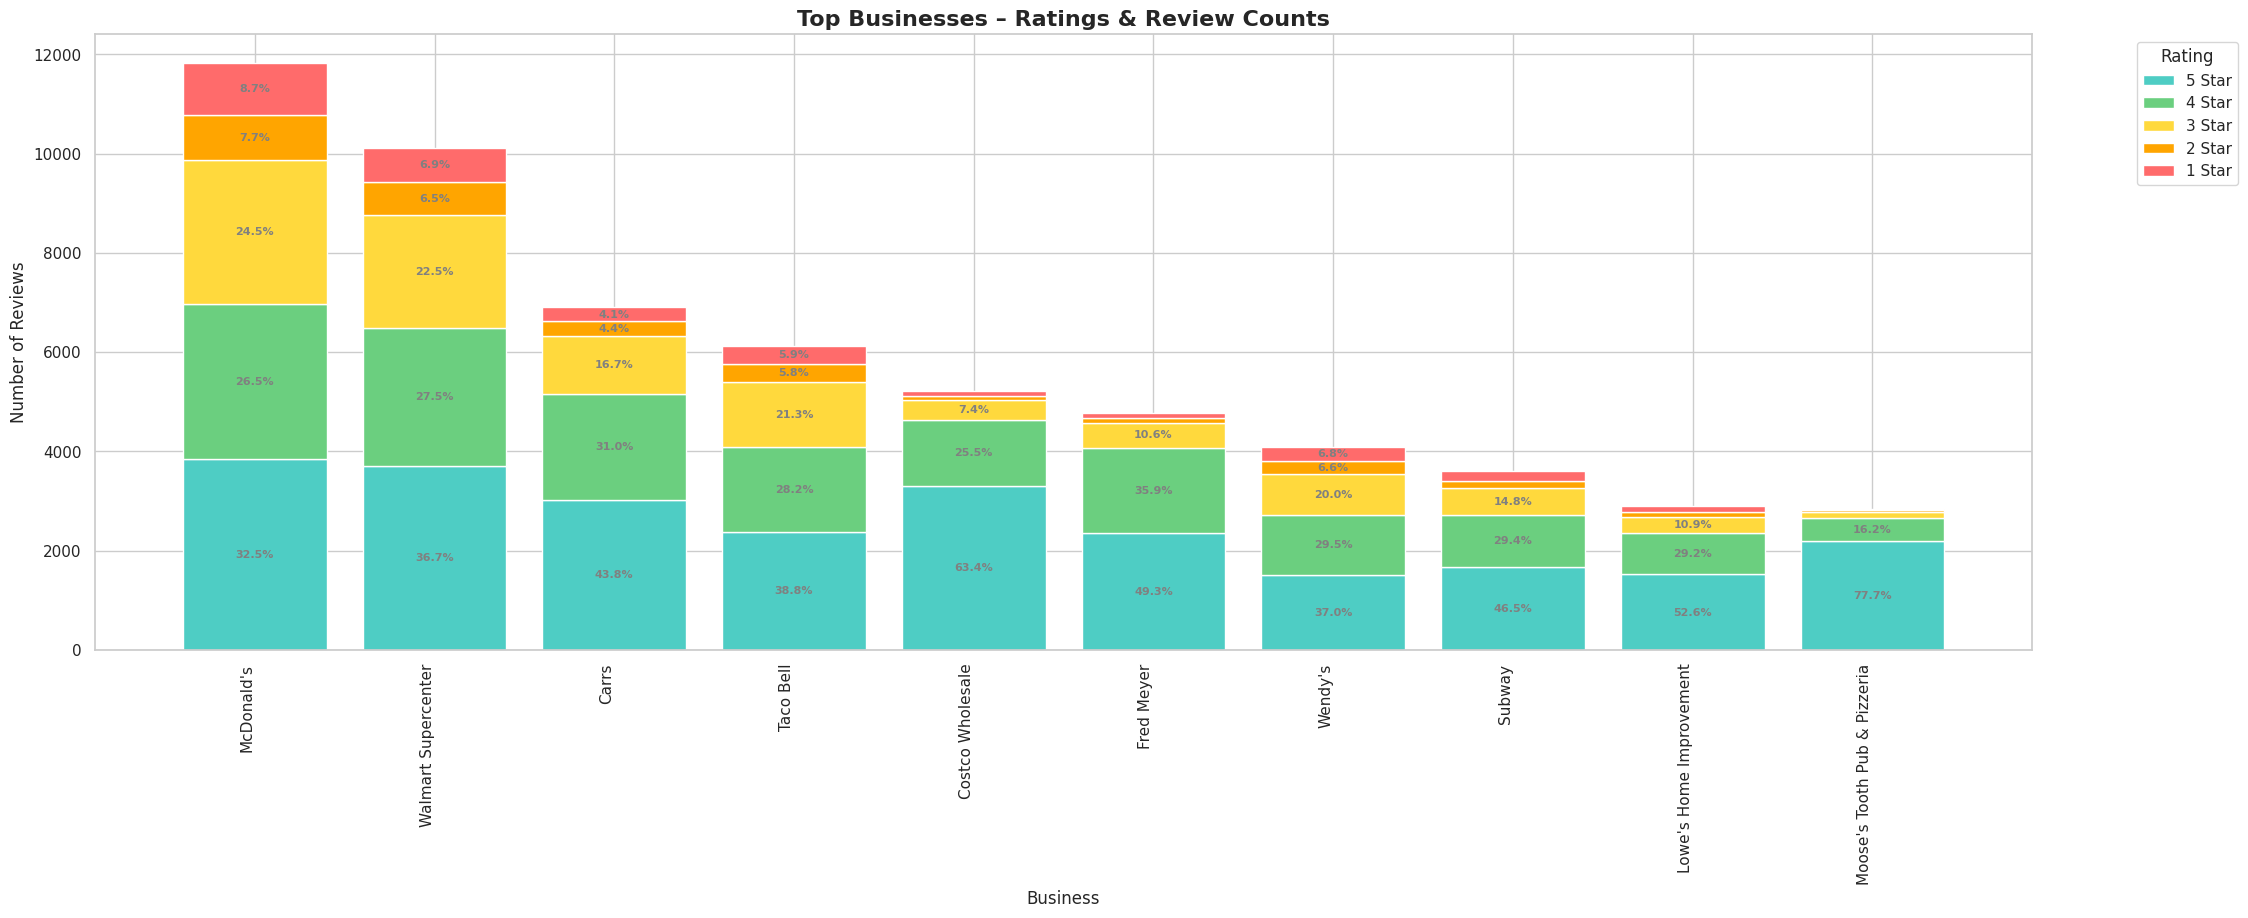

In [ ]:
import numpy as np

'''A more accurate way to represent reviews per business would be using
stacked bar charts that show the percentage breakdown of each rating level.'''

merged_df_temp = merged_df.copy()
merged_df_temp['rating'] = merged_df_temp['rating'].apply(np.ceil).astype(int)
# First, let's get the rating distribution for each top business

rating_counts = (
    merged_df_temp[merged_df_temp['business_name'].isin(reviews_by_biz['business_name'])]
    .groupby(['business_name', 'rating'])
    .size()
    .unstack(fill_value=0)
)

rating_colors = { 1: '#ff6b6b', 2: '#ffa500', 3: '#ffd93d', 4: '#6bcf7f', 5: '#4ecdc4'}
# Red for 1 star, Orange for 2 stars, Yellow for 3 stars, Light green for 4 stars, Light blue for 5 stars

# Total reviews per business
total_reviews = rating_counts.sum(axis=1)

rating_pct = rating_counts.div(total_reviews, axis=0) * 100

# necessary to order businesses by total reviews
rating_counts = rating_counts.loc[total_reviews.sort_values(ascending=False).index]
rating_pct = rating_pct.loc[rating_counts.index]

# Plot each rating category as a stacked bar
plt.figure(figsize=(25, 8))
bottom = np.zeros(len(rating_counts))

for rating in sorted(rating_counts.columns, reverse=True):
    plt.bar(
        rating_counts.index,
        rating_counts[rating],
        bottom=bottom,
        color=rating_colors[rating],
        label=f'{rating} Star'
    )
    bottom += rating_counts[rating]

plt.title("Top Businesses – Ratings & Review Counts", fontsize=16, fontweight='bold')
plt.xlabel("Business", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')


for i, biz in enumerate(rating_counts.index):
    cum = 0
    for rating in sorted(rating_counts.columns, reverse=True):
        count = rating_counts.loc[biz, rating]
        if count > 200:
            plt.text(
                i,
                cum + count / 2,
                f"{rating_pct.loc[biz, rating]:.1f}%",
                ha="center", va="center",
                fontsize=8, fontweight="bold", color="gray"
            )
        cum += count


**Creating a macro category calsification for businesess**

Previously, we found that **"['Hardware store', 'Home improvement store', 'Paint store', 'Tool store']"** was the category with the highest number of reviews.

However, this classification may be biased when trying to define the most common category, as the category column includes multiple subcategories and overlaps that could distort the representation. To address this, we introduced a set of macro categories that group related subcategories under broader labels, allowing for a more balanced and meaningful comparison across business types.

In [ ]:
import re
from collections import Counter
from wordcloud import STOPWORDS

# Ensure everything is a string, then join all category values
all_words = " ".join(merged_df["category"].fillna("").astype(str))

# Remove punctuation and lowercase everything
clean_text = re.sub(r"[^A-Za-z\s]", " ", all_words).lower()

# Split into tokens and remove stopwords/short words
tokens1 = [w for w in clean_text.split() if w not in STOPWORDS and len(w) > 2]

# Count frequencies
common_words = Counter(tokens1).most_common(15)

print(f"Most frequent words in column category.\n (First 15 Words sample)\n")
for word, freq in common_words:
    print(f"{word:20} {freq}")


Most frequent words in column category.
 (First 15 Words sample)

restaurant           515241
store                381064
shop                 125975
bar                  61180
service              51958
food                 49586
american             48872
grocery              47475
fast                 45337
tourist              41971
attraction           40428
breakfast            34364
pizza                34048
coffee               33426
hamburger            32194


We improved category classification by creating macro categories derived from the 200 most relevant words in the category column.

In [ ]:
from itertools import chain

# Defining each macro category
macro_keywords = {
    "Food & Drink":
     ["restaurant", "bar", "cafe", "coffee", "brewpub", "brewery", "pub", "grill", "bakery",
      "pizza", "fast", "hamburger", "sandwich", "takeout", "delivery", "seafood", "chicken",
      "cream", "lunch", "sushi", "steak", "buffet", "breakfast", "asian", "chinese", "italian",
      "japanese", "mex", "tex", "burrito", "taco", "vegetarian", "dessert", "wine", "cocktail",
      "barbecue", "wings", "brunch", "ice", "espresso"],

    "Retail & Shopping":
     ["store", "shop", "shopping", "goods", "gift",
      "electronics", "sports", "video","book", "hardware", "appliance", "phone", "cell",
      "liquor","supermarket", "grocery", "market", "discount", "yarn","supply", "supplier",
      "department", "warehouse", "materials", "equipment", "lighting", "improvement", "frame",
      "picture","furniture", "rug", "paint", "mall", "outlet","clothing", "shoe","toy"],

    "Vehicle Services":
     ["car", "auto", "dealer", "truck", "station", "motorcycle", "brake", "battery",
      "repair", "oil", "wash", "tire", "wheel", "change", "trailer", "parts", "propane", "gas"],

    "Lodging & Travel":
     ["hotel", "motel", "resort", "lodge", "campground", "hall","banquet", "airport", "visitor",
      "tour", "tourist","organization", "agency", "rental"],

    "Parks & Outdoor Recreation":
     ["park", "forest", "hiking", "campground", "outdoor", "hunting", "fishing", "wildlife",
      "ski", "recreation", "area", "field", "playground", "garden", "lawn", "complex"],

    "Health & Beauty":
     ["salon", "spa", "beauty", "body", "health", "treatment","veterinarian", "hair", "trainer",
      "physical", "therapy"],

    "Sports & Fitness": ["gym", "fitness", "sporting", "sports"],

    "Arts & Entertainment":
     ["museum", "theater", "amusement", "movie", "music", "art", "concert", "event", "club", "video"],

    "Home & Garden":
     ["home", "house", "garden", "flooring", "window", "building","bathroom", "cabinet", "hardware",
      "lawn", "improvement","materials", "paint", "clean", "appliance"],

    "Business & Professional":
     ["business", "company", "organization", "provider", "service", "non", "profit", "agency"],
}

# Build the flat dictionary
macro_map = {
    kw: category
    for category, keywords in macro_keywords.items()
    for kw in keywords
}

# Since not all words fall into the macro categories, the remaining words are classified as other.
macro_map[""] = "Other"

Macro categories that group related subcategories under broader labels:


*   Food & Drink
*   Retail & Shopping
*   Vehicle Services
*   Lodging & Travel
*   Parks & Outdoor Recreation
*   Health & Beauty
*   Sports & Fitness
*   Arts & Entertainment
*   Home & Garden
*   Business & Professional










In [ ]:
def classify_category(cat_value):
    """
    cat_value: string or list of strings (e.g., from your 'category' column)
    returns: macro category (first match) or 'Other'
    """
    # Turn list into a single string and lowercase
    if isinstance(cat_value, list):
        text = " ".join(cat_value).lower()
    else:
        text = str(cat_value).lower()

    for keyword, macro in macro_map.items():
        if keyword and keyword in text:
            return macro
    return "Other"



In [ ]:
merged_df["macro_category"] = merged_df["category"].apply(classify_category)

merged_df["macro_category"].value_counts()

# Number of reviews by macro category

macro_category
Food & Drink                  282516
Retail & Shopping             112883
Lodging & Travel               57037
Other                          17006
Vehicle Services               14500
Parks & Outdoor Recreation     13709
Health & Beauty                 7976
Arts & Entertainment            6938
Business & Professional         4736
Sports & Fitness                3955
Home & Garden                    741
Name: count, dtype: int64

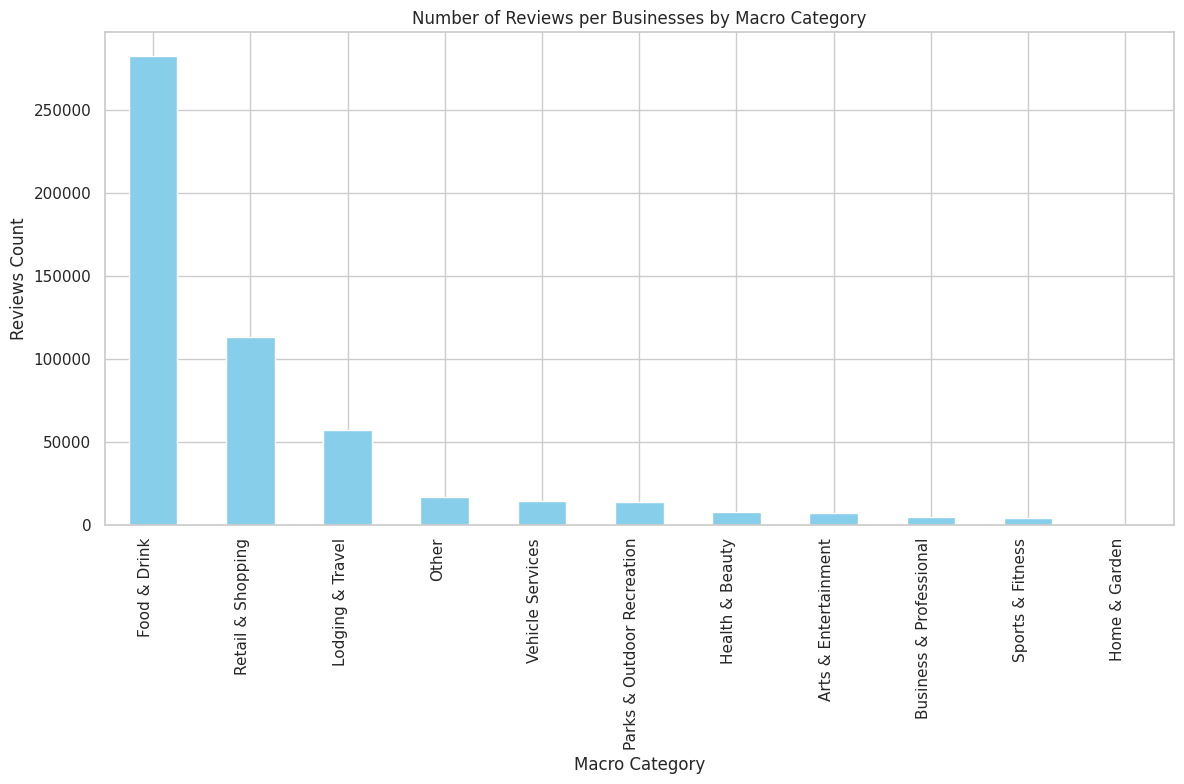

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
(
    merged_df["macro_category"]
    .value_counts()
    .plot(kind="bar", color="skyblue")
)
plt.title("Number of Reviews per Businesses by Macro Category")
plt.xlabel("Macro Category")
plt.ylabel("Reviews Count")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


To improve the interpretability of business categories, we first extracted the most frequent keywords from the original "category" column. Based on this analysis, we defined a set of representative macro categories such as Food & Drink, Retail & Shopping, and Vehicle Services that capture the dominant themes across the dataset. Each business entry was then mapped to one of these macro categories, and the aggregated counts were visualized using a bar chart.

The results show that Food & Drink is by far the most prevalent category (282,516 entries), followed by Retail & Shopping (112,883) and Lodging & Travel (57,037). Less common categories include Home & Garden (741) and Sports & Fitness (3,955), with a residual "Other" group (17,006) including entries that did not fit into the predefined categories.

## **Question 1.4**

**Review Trends and Word Clouds by Year**

In [ ]:
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

merged_df['year'] = merged_df['time'].dt.year # required later for wordcloud

In [ ]:
'''The function is used to perfrom text mining. It clears the text and gives a
clear text in return while performing the operaions explained.'''

def clean_text(text):
    """
    Clean and normalise review text:Lowercase, Remove punctuation, digits, special chars, Remove stopwords
    Collapse multiple spaces
    """
    if not isinstance(text, str):
        return ""

    text = text.lower() # Lowercase
    text = re.sub(r"[^a-z\s]", " ", text) # Keep only letters and whitespace
    text = re.sub(r"\s+", " ", text).strip()# Collapse extra spaces

    tokens = [word for word in text.split() if word not in STOPWORDS] # Remove stopwords

    return " ".join(tokens)

In [ ]:
''' Stopwords refer to commonly used words—such as "the", "is", or "and"
that are typically filtered out because they have minimal value.'''

print(STOPWORDS)

{'cannot', 'each', 'from', 'over', "wouldn't", 'by', 'had', 'again', "i'd", 'does', 'then', 'was', 'if', 'it', 'where', "where's", 'just', "she's", "he's", 'your', 'into', 'same', 'therefore', "here's", 'because', 'their', 'before', 'theirs', 'to', 'on', "didn't", "what's", "you're", 'yourselves', 'i', 'not', 'we', 'doing', "there's", 'has', 'com', 'and', 'there', "hadn't", 'having', 'his', 'my', 'were', 'do', 'r', "why's", 'very', 'both', 'few', "they're", "you'd", 'other', 'have', "she'd", 'against', 'so', 'whom', 'until', 'when', 'ours', 'itself', "i'll", 'after', "let's", 'she', 'once', "wasn't", "doesn't", 'no', "that's", 'while', "they'll", 'any', 'up', "aren't", 'such', "weren't", 'been', 'at', 'here', 'nor', 'shall', 'off', 'most', 'or', 'but', 'these', 'about', "we'll", 'during', "when's", 'ought', 'themselves', "it's", 'in', "shouldn't", 'ever', 'they', 'is', 'yours', 'since', 'me', 'like', 'being', "we've", 'hers', 'them', 'are', 'hence', "he'd", 'himself', "couldn't", 'betw

In [ ]:
# Creating a copy of the dataframe to work with Review Trends and Word Clouds
df_text_mining = merged_df.copy()

# Making a new column named 'clean_text' that has the cleaned text

df_text_mining['clean_text'] = df_text_mining['text'].apply(clean_text)

print(f"Column text before and after cleaning.\n")
df_text_mining[['text', 'clean_text']].head()

Column text before and after cleaning.



text  \
0  We always stay here when in Valdez for silver ...   
1  We always stay here when in Valdez for silver ...   
2  Great campground for the price. Nice hot unlim...   
3  Great campground for the price. Nice hot unlim...   
4  We tent camped here for 2 nights while explori...   

                                          clean_text  
0  always stay valdez silver salmon fishing elder...  
1  always stay valdez silver salmon fishing elder...  
2  great campground price nice hot unlimited show...  
3  great campground price nice hot unlimited show...  
4  tent camped nights exploring valdez center cam...

In [ ]:
print("Text -")
print(df_text_mining['text'].iloc[1])
print("\n")
print("Clean text -")
print(df_text_mining['clean_text'].iloc[1])

Text -
We always stay here when in Valdez for silver salmon fishing. The elderly couple that run it are amazing to talk to, extremely helpful. The campsites are very well maintained.


Clean text -
always stay valdez silver salmon fishing elderly couple run amazing talk extremely helpful campsites well maintained


To prepare the text data for analysis, we applied a preprocessing step that involved converting all characters to lowercase and removing punctuation.

Additionally, we filtered out common stopwords, such as "the," "and," "of" which typically do not contribute meaningful information to the classification task. This cleaning process keep core content, allowing for more accurate keyword extraction and category mapping.

In [ ]:
# Finding top 30 frequent Words

# Joining all the words in the clean_text column
all_words = " ".join(df_text_mining['clean_text'].fillna("").astype(str))

# Including 'review' in the stopwords does not add meaningful information
STOPWORDS = set(STOPWORDS)
STOPWORDS.add("review")

# Splitting into tokens
tokens = [w for w in all_words.split() if w not in STOPWORDS and len(w) > 2]

# Top 30 most frequent words
common_words = Counter(tokens).most_common(30)


In [ ]:
# Making a dataframe for top 30 common words from the data
common_df = pd.DataFrame(common_words, columns = ['word', 'count'])
print(f"Most frequent words in column clean_text the one with customer's reviews\n")
common_df

Most frequent words in column clean_text the one with customer's reviews



word  count
0       great  83356
1        good  64716
2        food  63822
3       place  48230
4     service  46136
5       staff  29074
6    friendly  26673
7        nice  26645
8      always  23784
9        best  22082
10       love  20043
11       time  19145
12        one  15984
13      clean  12748
14     people  12728
15     really  12686
16       will  12645
17    amazing  12623
18     prices  12361
19      store  12242
20    awesome  12170
21       back  12031
22       well  11845
23    helpful  10756
24     little  10491
25  excellent  10370
26   customer   9555
27        got   9540
28  delicious   9480
29  selection   9420

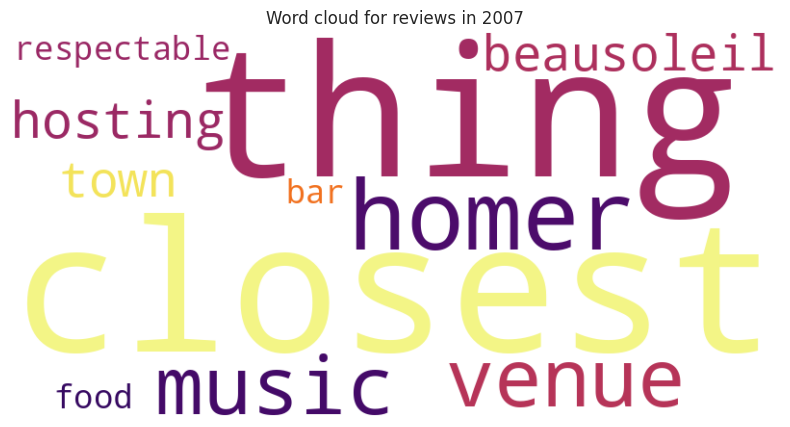

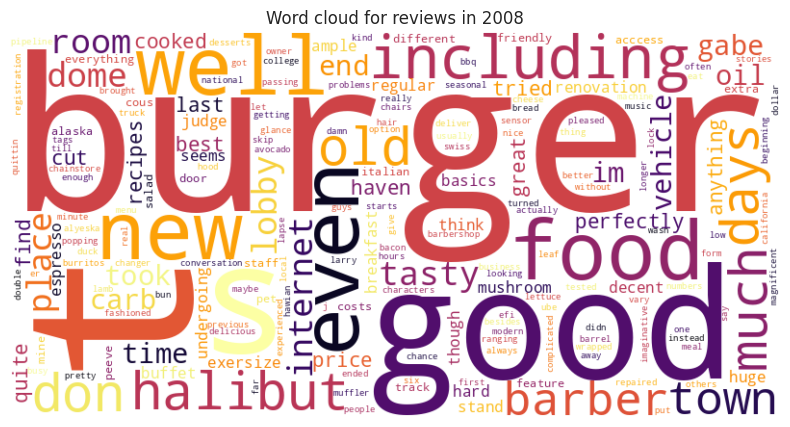

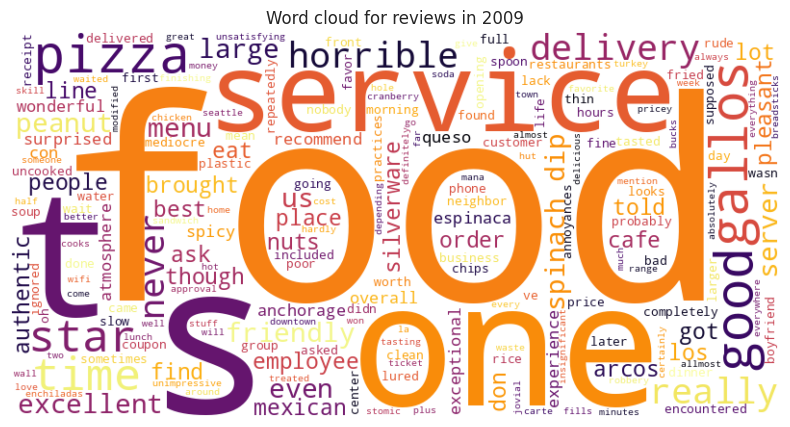

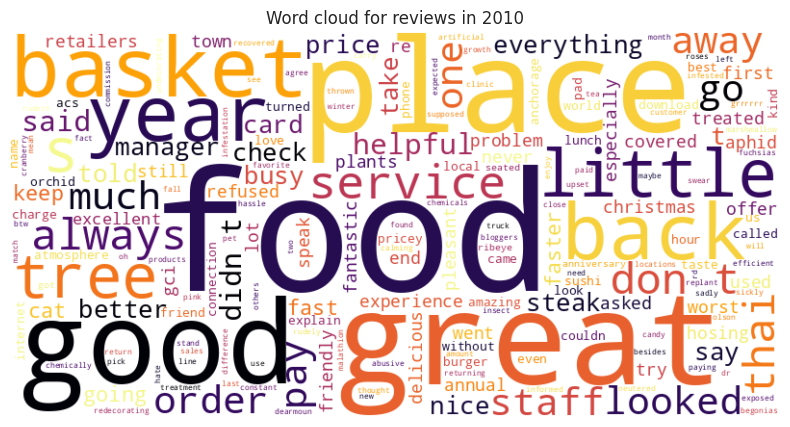

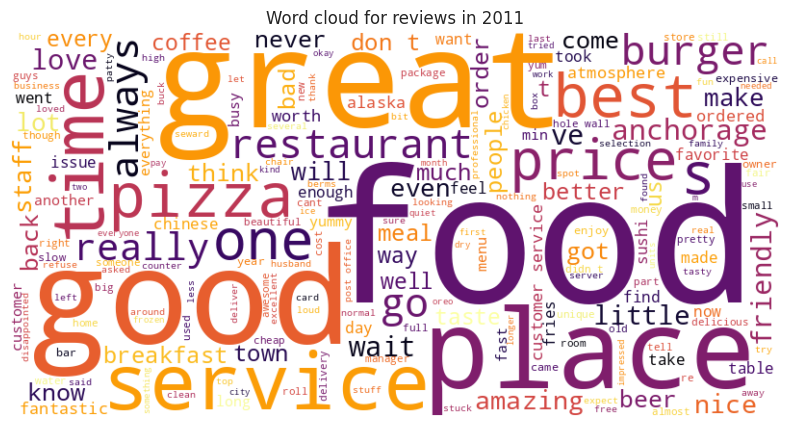

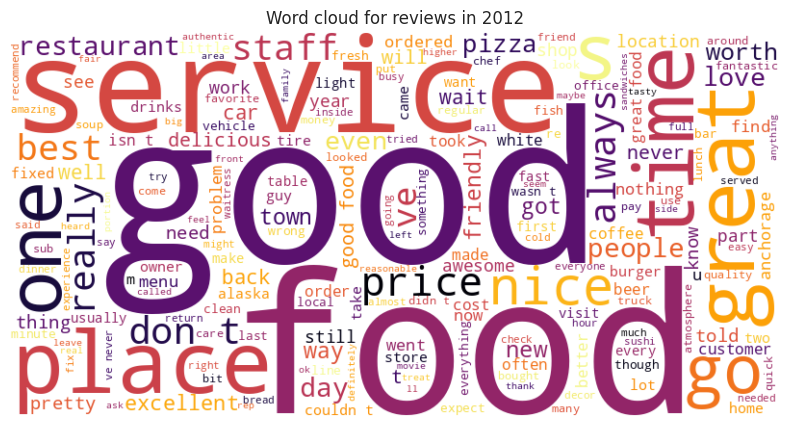

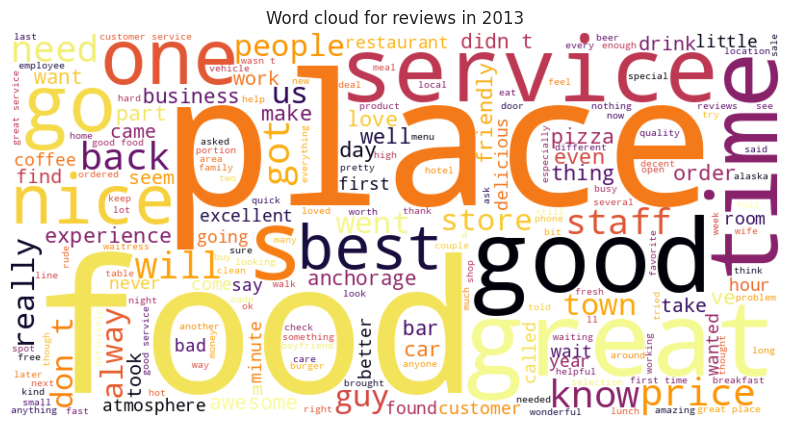

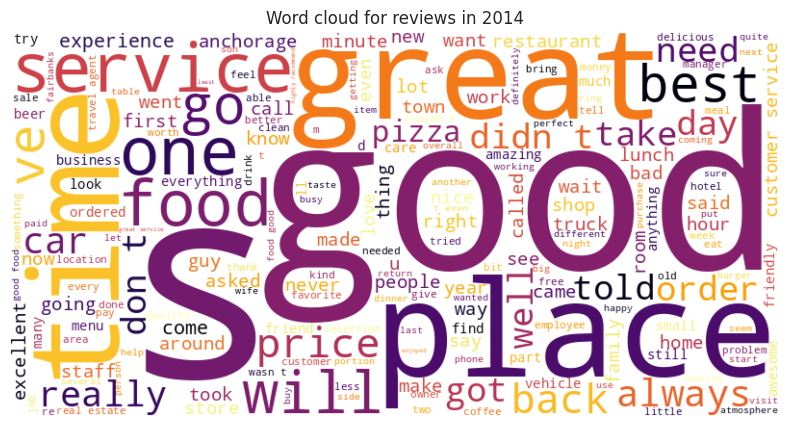

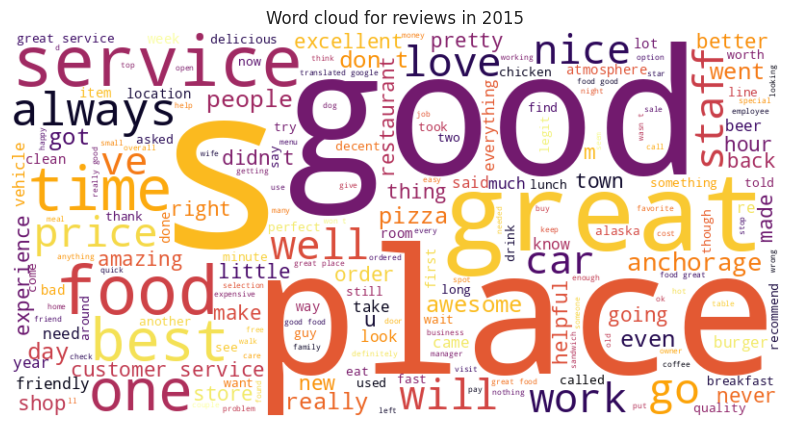

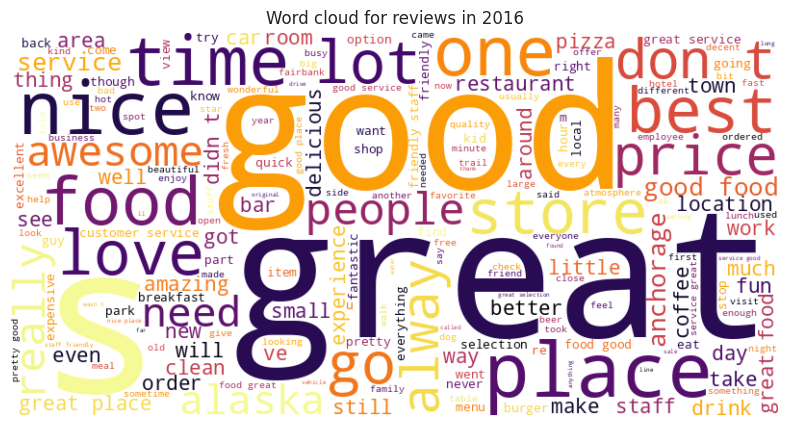

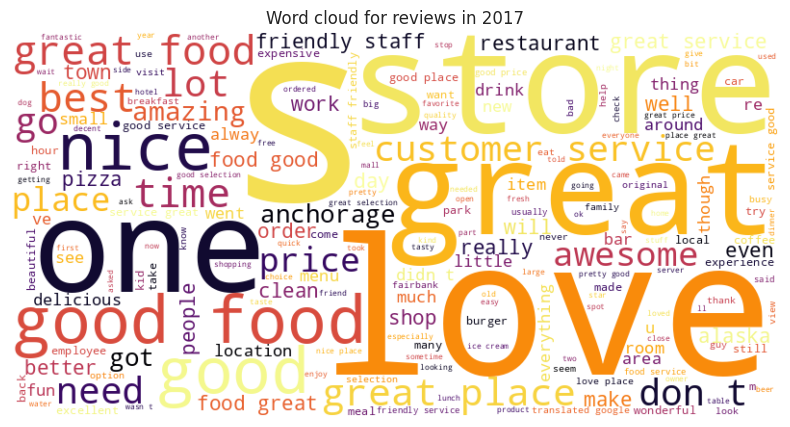

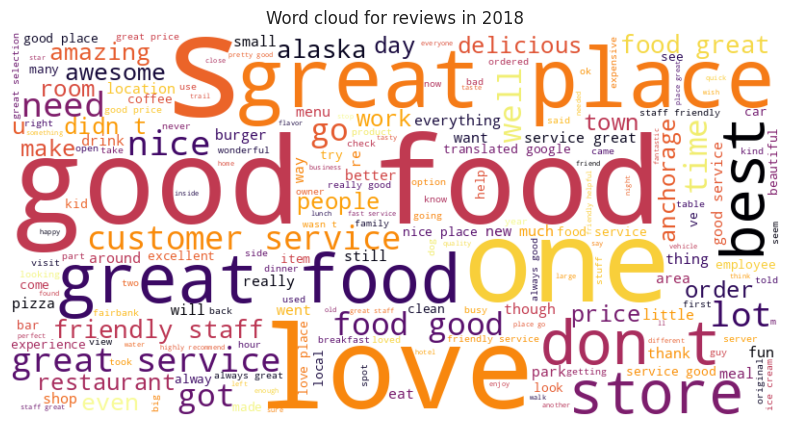

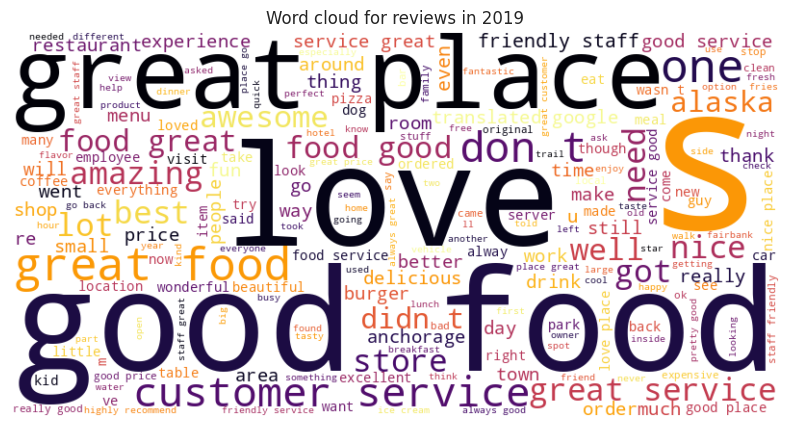

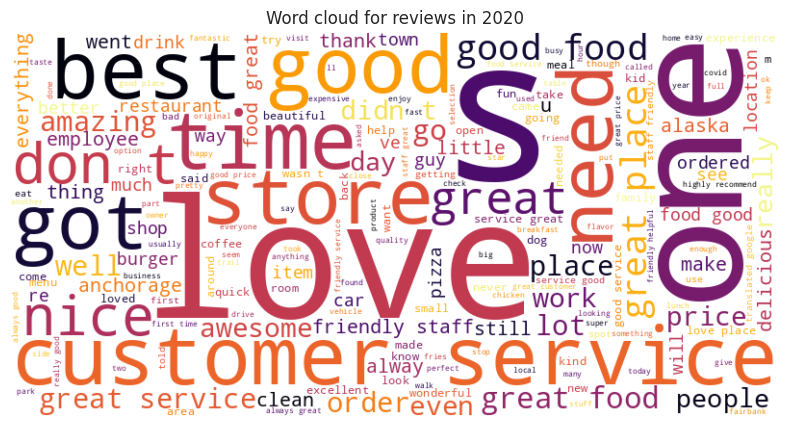

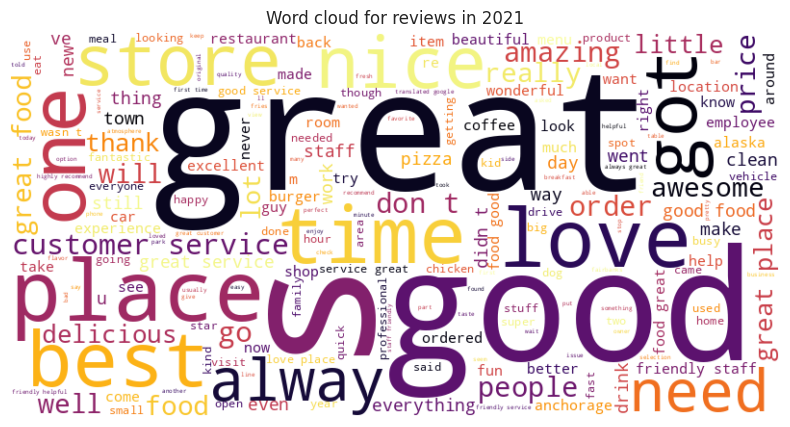

In [ ]:
'''Different themes for the wordcloud.
Just put any of these values in the colormap attribute -
["viridis", "plasma", "inferno", "coolwarm", "Set3"]'''

# Word cloud
years = merged_df["year"].unique()

for year in sorted(years):
  year_text = " ".join(
      df_text_mining.loc[df_text_mining['year'] == year, 'clean_text']
      .fillna("")
      .astype(str)
      )
  wc = WordCloud(
      width = 800, height = 400, # size of the image
      background_color = 'white', # white background
      stopwords = STOPWORDS,
      colormap = 'inferno' # color scheme for words
  ).generate(year_text)
  plt.figure(figsize = (10, 5))
  plt.imshow(wc, interpolation = 'bilinear')
  plt.axis('off')
  plt.title(f"Word cloud for reviews in {year}")
  plt.show()
  print("")

We performed the NLP tasks in this phase. We performed tokenization by removing the stop words and taking the base form of the word. After this, we took the tokenized base words and found their count in the whole data by combining every row by split("").
<br>
Later, we made a word cloud according to the year which gives the most frequent word in that particular year.

## **Question 1.5**

**Analysis on the business_name and the reviewers**

In [ ]:
# To find the unique reviewrs, we use the user_id field

# Unique reviewers at the business level
unique_reviewers_business = (
    merged_df.groupby(['gmap_id', 'business_name', 'category'])['user_id']
    .nunique()
    .reset_index(name = 'unique_reviewers')
    .sort_values('unique_reviewers', ascending = False)
)
# Top 10 businesses reviewed by the unique reviewers
unique_reviewers_business.head(10)


gmap_id                   business_name  \
3593  0x56c897b9ce6000df:0xd707e127588a8c6c    Moose's Tooth Pub & Pizzeria   
4370  0x56c899d058920487:0x12882cc9133f2f54                   Dimond Center   
3730  0x56c897c63697ee39:0x419904ababbc740b             Walmart Supercenter   
2881  0x56c8965ee2fb87a1:0x559736347bd48842                Costco Wholesale   
2653   0x56c89629bde7481f:0x7e8a9413ab25d5d       Anchorage 5th Avenue Mall   
4364  0x56c899cd61bbf82b:0x544a5b80b67a93c7                Costco Wholesale   
4733  0x56c8bd86fd671871:0x52c896e66d960c02  49th State Brewing - Anchorage   
4368  0x56c899d0184538f9:0xfcf4420cda19d613             Walmart Supercenter   
2463  0x56c8942639bddcf1:0x3d4151966bed9375                Tikahtnu Commons   
3009  0x56c8969817c5b323:0xfd52c71fe0d827f1             Walmart Supercenter   

                                               category  unique_reviewers  
3593  ['Pizza restaurant', 'Bar', 'Brewpub', 'Restau...              2833  
4370                                  ['Shopping mall']              2542  
3730  ['Department store', 'Clothing store', 'Craft ...              2200  
2881            ['Warehouse store', 'Department store']              2164  
2653                                  ['Shopping mall']              2116  
4364            ['Warehouse store', 'Department store']              1820  
4733                          ['Brewpub', 'Restaurant']              1761  
4368  ['Department store', 'Clothing store', 'Craft ...              1723  
2463                                  ['Shopping mall']              1713  
3009  ['Department store', 'Clothing store', 'Craft ...              1585

In [ ]:
print(len(unique_reviewers_business))

6012


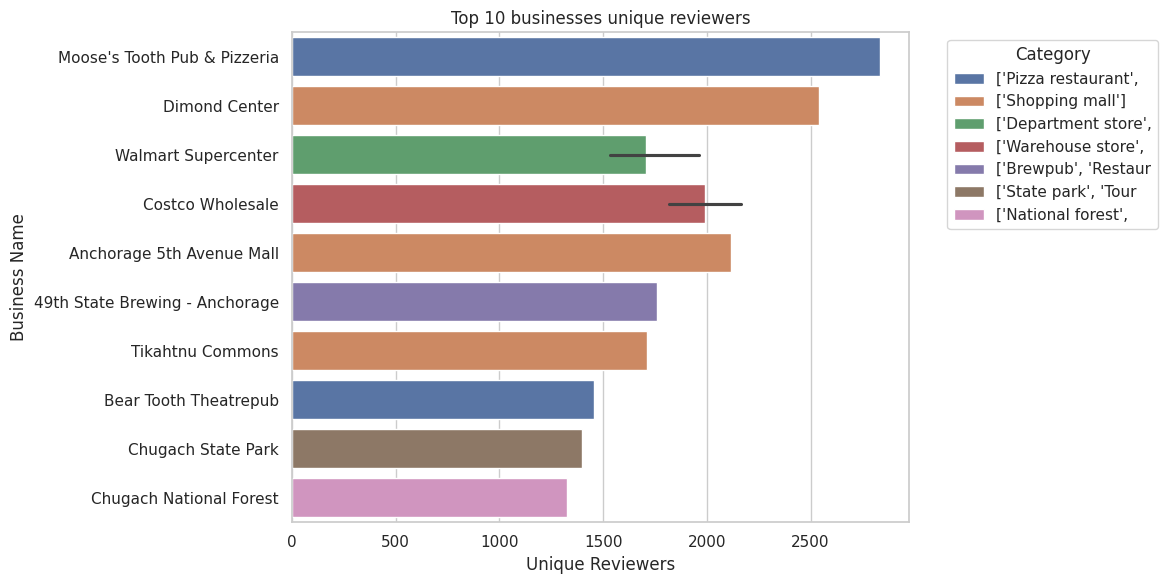

In [ ]:
top10_business_reviewers = unique_reviewers_business.head(15).copy()
top10_business_reviewers["short_category"] = top10_business_reviewers["category"].str.slice(0, 20)
# It's necessary to shorten the category names to improve plot readability

plt.figure(figsize = (12, 6))
sns.barplot(data = top10_business_reviewers,
            x = 'unique_reviewers',
            y = 'business_name',
            hue = 'short_category',
            dodge = False
            )
plt.title("Top 10 businesses unique reviewers")
plt.xlabel("Unique Reviewers")
plt.ylabel("Business Name")
plt.legend(title = "Category", bbox_to_anchor=(1.05, 1), loc = "upper left")
plt.tight_layout()
plt.show()

As seen from the bar plot, the business "Moose's Tooth Pub & Pizzeria" has the highest number of unique business reviewers.

On the other hand, "Chugach National Forest" has the lowest number of unique reviewers.

In [ ]:
# unique reviewers per category
unique_reviews_category = (
    merged_df.groupby(['category'])['user_id']
    .nunique()
    .reset_index(name = 'unique_reviewers')
    .sort_values('unique_reviewers', ascending = False)
)

unique_reviews_category.head(5)

category  unique_reviewers
2189                                  ['Shopping mall']              7176
866   ['Department store', 'Clothing store', 'Craft ...              7092
993   ['Fast food restaurant', 'Breakfast restaurant...              6951
1206      ['Grocery store', 'Grocery delivery service']              5795
1628                             ['Mexican restaurant']              5062

In [ ]:
# unique reviewers per macro_category
unique_reviews_macro_category = (
    merged_df.groupby(['macro_category'])['user_id']
    .nunique()
    .reset_index(name = 'unique_reviewers')
    .sort_values('unique_reviewers', ascending = False)
)

unique_reviews_macro_category.head(5)



macro_category  unique_reviewers
2        Food & Drink             19967
8   Retail & Shopping             18036
5    Lodging & Travel             15074
6               Other              9357
10   Vehicle Services              7667

**Top10 unique reviews by category**

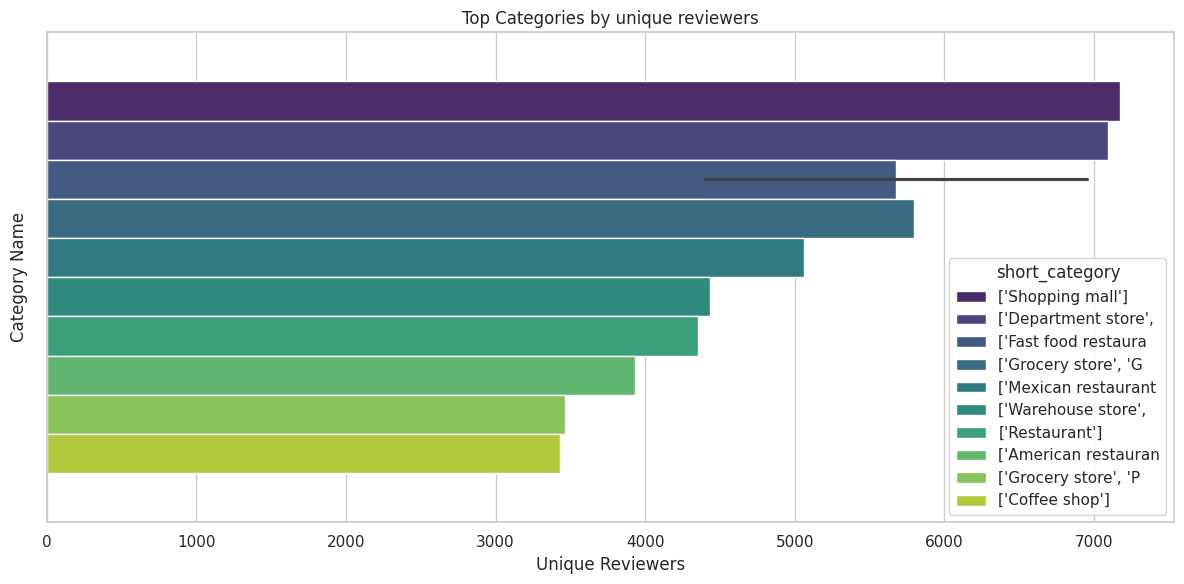

In [ ]:
top10_unique_reviewers_by_category = unique_reviews_category.head(11).copy()
top10_unique_reviewers_by_category["short_category"] = top10_unique_reviewers_by_category["category"].str.slice(0, 20)

plt.figure(figsize = (12, 6))
sns.barplot(data = top10_unique_reviewers_by_category,
            x = 'unique_reviewers',
            hue = 'short_category',
            palette =  'viridis'
            )
plt.title("Top Categories by unique reviewers")
plt.xlabel("Unique Reviewers")
plt.ylabel("Category Name")
plt.tight_layout()
plt.show()

**Top10 unique reviews by macro category**

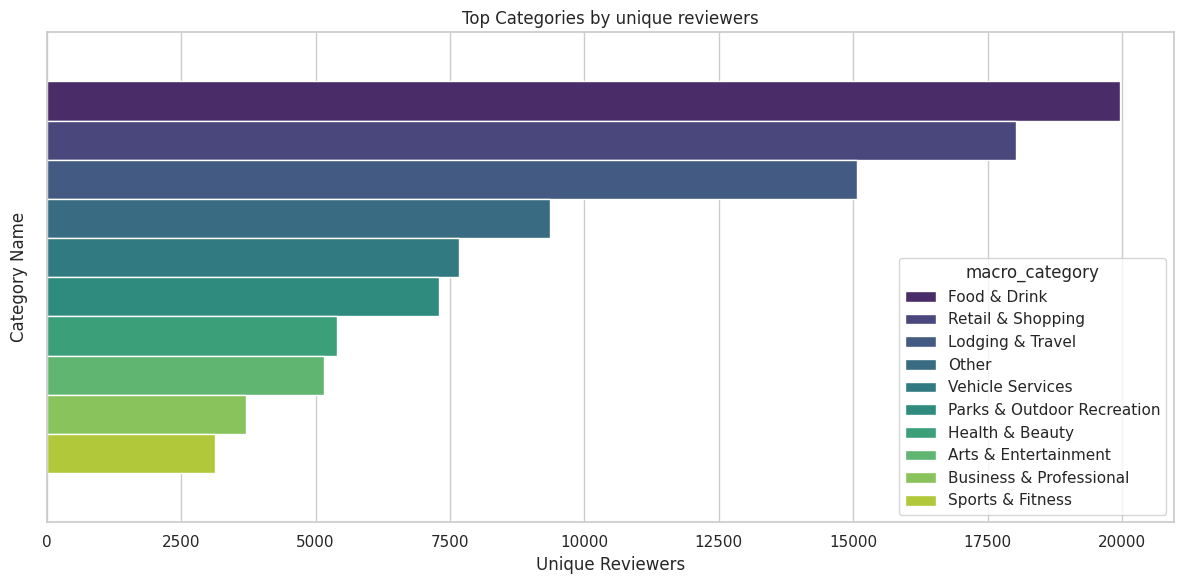

In [ ]:

top10_unique_reviews_macro_category = unique_reviews_macro_category.head(10)

plt.figure(figsize = (12, 6))
sns.barplot(data = top10_unique_reviews_macro_category,
            x = 'unique_reviewers',
            hue = 'macro_category',
            palette =  'viridis'
            )
plt.title("Top Categories by unique reviewers")
plt.xlabel("Unique Reviewers")
plt.ylabel("Category Name")
plt.tight_layout()
plt.show()

In [ ]:
merged_df.info()

# To find the temporal patterns by weekday, year, month, hour.
# As seen in the columns, we have the weekday, year and hours columns.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521997 entries, 0 to 521996
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           521997 non-null  float64       
 1   reviewer_name     521997 non-null  object        
 2   time              521997 non-null  datetime64[ns]
 3   rating            521997 non-null  int32         
 4   text              521997 non-null  object        
 5   pics              20871 non-null   object        
 6   resp              44306 non-null   object        
 7   gmap_id           521997 non-null  object        
 8   newtime           521997 non-null  object        
 9   review_time       521997 non-null  object        
 10  business_name     521997 non-null  object        
 11  address           521341 non-null  object        
 12  description       263503 non-null  object        
 13  latitude          521997 non-null  float64       
 14  long

In [ ]:
# To find the temporal pattern by month, adding that particular column in the merged_df'
merged_df['month'] = merged_df['time'].dt.month_name()

merged_df[['Weekday', 'year', 'month']].head()

Weekday  year      month
0   Tuesday  2019     August
1   Tuesday  2019     August
2  Saturday  2017  September
3  Saturday  2017  September
4    Sunday  2016  September

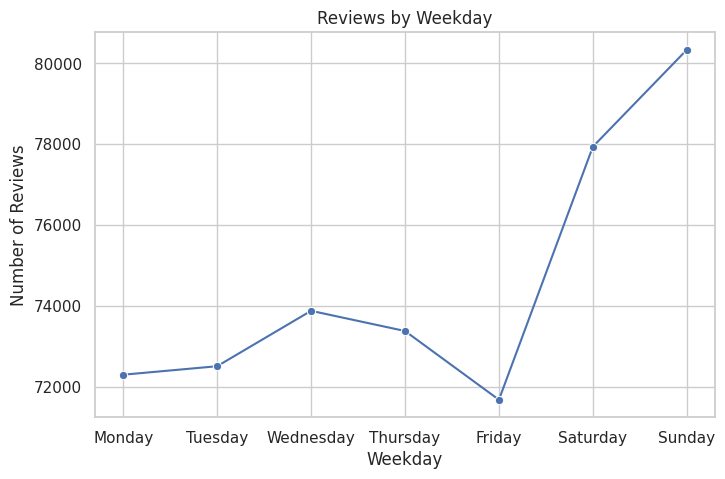

In [ ]:
# Reviews by weekday

reviews_by_day = (
    merged_df.groupby("Weekday")['user_id']
    .count()
    .reset_index(name="review_count")
)

reviews_by_day['Weekday'] = pd.Categorical(reviews_by_day['Weekday'],
                                           categories = weekday_order, ordered=True)
reviews_by_day = reviews_by_day.sort_values("Weekday")

plt.figure(figsize=(8,5))
sns.lineplot(data=reviews_by_day,
             x = "Weekday",
             y = "review_count",
             marker = "o")
plt.title("Reviews by Weekday")
plt.ylabel("Number of Reviews")
plt.show()

Sunday recorded over 80,000 reviews, making it the most active day, whereas Friday had fewer than 72,000 reviews, the lowest volume across the week.

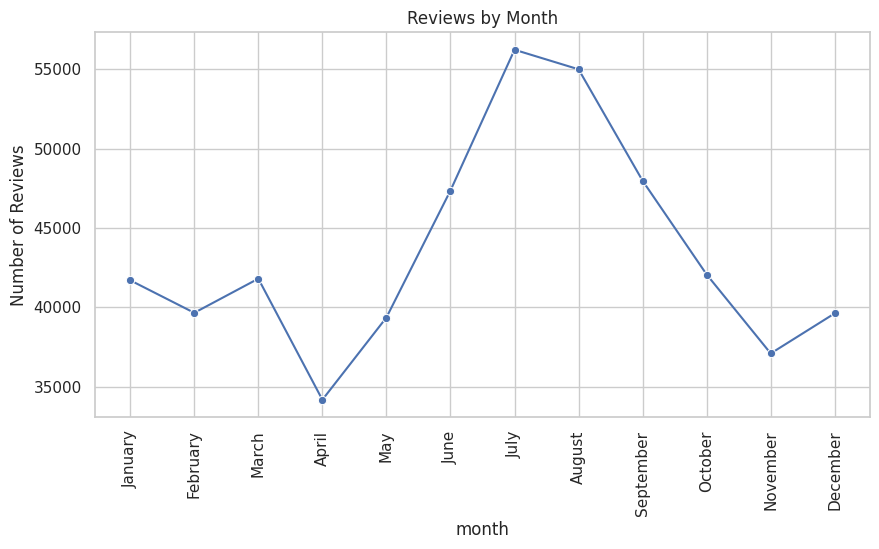

In [ ]:
# Reviews by month
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

reviews_by_month = (
    merged_df.groupby("month")['user_id']
    .count()
    .reset_index(name = "review_count")
)

reviews_by_month['month'] = pd.Categorical(reviews_by_month['month'],
                                           categories = month_order,
                                           ordered = True)
reviews_by_month = reviews_by_month.sort_values("month")

plt.figure(figsize = (10,5))
sns.lineplot(data = reviews_by_month,
             x = "month",
             y = "review_count",
             marker = "o")
plt.title("Reviews by Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation = 90)
plt.show()

The most number of reviews are in the month of July, which is more than 55000.

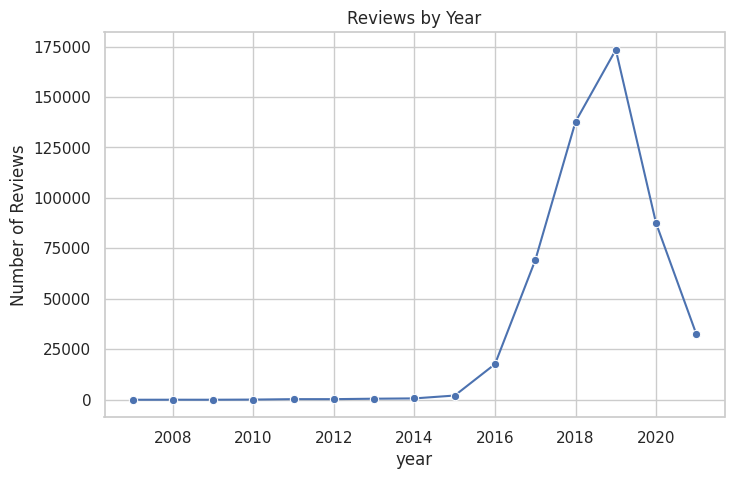

In [ ]:
# Reviews by year
reviews_by_year = (
    merged_df.groupby("year")['user_id']
    .count()
    .reset_index(name = "review_count")
)

plt.figure(figsize = (8,5))
sns.lineplot(data = reviews_by_year,
             x = "year",
             y = "review_count",
             marker = "o")
plt.title("Reviews by Year")
plt.ylabel("Number of Reviews")
plt.show()

<p>
  <b>Temporal patterns</b>
  <ol>
    <li>By Weekday</li>
    <p>
      We can see that <b>Sunday</b> has the most number of reviewers.
    </p>
    <li>By Year</li>
    <p>
      It is evident from the linechart, the year <b>2019</b> has had the most number of reviewers.
    </p>
    <li>By Month</li>
    <p>
      The most number of reviewers are in the month of <b>July</b>.
    </p>
  </ol>
</p>

## **Question 1.6**

### ***Question 1.6.1***

**Strategy for Building Business Recommendations Using Collaborative Filtering (KNN)**



To generate personalized business recommendations for customers, we implemented an item-based collaborative filtering approach using the K-Nearest Neighbors (KNN) algorithm. This strategy leverages customer ratings to identify businesses that are similar in terms of user preferences.

**Step-by-Step Strategy:**

1. **Data Preparation**  
   Construct a user-item matrix from the merged dataset, where:
   - Rows represent individual users (`user_id`)
   - Columns represent businesses (`business_name`)
   - Cell values correspond to user ratings for each business  
   Missing ratings were filled with zeros to ensure matrix completeness.

2. **Sparse Matrix Conversion**  
   Since the user-item matrix is typically sparse (most users rate only a few businesses), We converted it into a compressed sparse row (CSR) format using `scipy.sparse.csr_matrix`. This improves memory efficiency and speeds up similarity computations.

3. **Model Training with KNN**  
   Training a KNN model using cosine similarity, which is well-suited for sparse data and measures the angle between rating vectors rather than their magnitude. The model was fit on the transposed user-item matrix to compute item-item (business-business) similarities.

4. **Generating Recommendations**  
   For a given business, the model retrieves its nearest neighbors—i.e., Businesses with similar rating patterns across users. The top N recommendations are selected based on similarity scores (1 - cosine distance), excluding the business itself.

5. **Evaluation and Demonstration**  
   Test the system by generating recommendations for a sample business and iterate over a subset of businesses to produce a sample recommendation set. These outputs may demonstrate the ability of the model to suggest alternatives that align with user preferences.
   
   
Why This Strategy Works

- **Scalability**: Using sparse matrices and cosine similarity allows the system to scale efficiently across large datasets.
- **Personalization**: Recommendations are based on actual user behavior, making them more relevant than popularity-based methods.
- **Interpretability**: The similarity scores provide a transparent measure of how closely businesses are related.

This approach can be extended by incorporating user-based filtering, hybrid models, or additional metadata (e.g., business categories or location) to further refine recommendations.


### ***Question 1.6.2***

**Implementing the strategy code.**

In [ ]:
# Collaborative Filtering with KNN
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np

# Create a user-item matrix (pivot table)
user_item_matrix = merged_df.pivot_table(
    index='user_id',
    columns='business_name',
    values='rating',
    fill_value=0
)

# Convert to sparse matrix for efficient computation
sparse_user_item = csr_matrix(user_item_matrix.values)

# Build the KNN model on items (businesses)
# Using cosine similarity as it works well with sparse data
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(sparse_user_item.T)  # Transpose to get item-item similarities

# Function to get business recommendations
def get_recommendations(business_name, n_recommendations=5):
    """
    Get similar businesses using KNN collaborative filtering
    """
    # Find the index of the requested business
    business_idx = user_item_matrix.columns.get_loc(business_name)

    # Find similar businesses
    distances, indices = model_knn.kneighbors(
        sparse_user_item.T[business_idx],
        n_neighbors=n_recommendations+1
    )

    # Get the list of similar businesses
    similar_businesses = []
    for i in range(1, len(indices.flatten())):
        similar_business = user_item_matrix.columns[indices.flatten()[i]]
        similarity = 1 - distances.flatten()[i]  # Convert distance to similarity
        similar_businesses.append((similar_business, similarity))

    return similar_businesses

# Test the recommendation system with a sample business
sample_business = user_item_matrix.columns[0]  # Get the first business as an example
recommendations = get_recommendations(sample_business)

# Generate recommendations for all businesses
business_recommendations = {}
for business in user_item_matrix.columns[:10]:  # Limit to first 10 for demonstration
    business_recommendations[business] = get_recommendations(business)

print("\nSample of business recommendations:\n")
for business, recs in list(business_recommendations.items())[:3]:
    print(f"\nFor '{business}':")
    for rec, sim in recs:
        print(f"  - {rec} (similarity: {sim:.3f})")


Sample of business recommendations:


For '1-800-GOT-JUNK? Anchorage':
  - JBER Veterinary Clinic (similarity: 0.119)
  - Mat-Su Urgent Care Palmer (similarity: 0.085)
  - Aurora Military Housing - Richardson (similarity: 0.084)
  - Alaska Scrap & Recycling (similarity: 0.080)
  - Arctic Tails (similarity: 0.078)

For '108 Tap House & Burger Bar':
  - Local Grounds Coffee (similarity: 0.361)
  - Rain Country Nutrition (similarity: 0.319)
  - New York Cafe (similarity: 0.300)
  - Fat Stan's Sports Bar & Pizzeria (similarity: 0.287)
  - Bar Harbor Ale House (similarity: 0.266)

For '10th & M Seafoods':
  - Alaska Spine and Pain Center (similarity: 0.111)
  - Johnson's Tire Service- Midtown Anchorage (similarity: 0.108)
  - Rainbow Foods (similarity: 0.104)
  - Bentley's Porter House B & B (similarity: 0.102)
  - Mint Dental (similarity: 0.091)


The recommendation system uses item-based collaborative filtering with KNN to identify businesses that share similar user rating patterns. The similarity scores are derived from cosine similarity, which measures the angle between rating vectors—higher scores indicate stronger similarity.

 Key Observations from the Results

1. '1-800-GOT-JUNK? Anchorage'

These results suggest that users who rated '1-800-GOT-JUNK?' business also. Interacted with services related to pet care, housing, recycling, and healthcare. While these businesses differ in category, their co-occurrence in user ratings implies a shared customer base or similar service expectations.

2. '108 Tap House & Burger Bar'

The high similarity values indicate that users who rated this burger bar also rated other dining and beverage establishments, reflecting consistent preferences within the food service domain.

3. '10th & M Seafoods'

This mix of healthcare, automotive, and food services suggests that users who rated this seafood business have diverse interests, possibly tied to location or lifestyle patterns.

 Interpretation of Similarity Scores

- Scores range from 0 to 1, where values closer to 1 indicate stronger similarity.
- A score above 0.3 (as seen with food venues) reflects a meaningful overlap in user preferences.
- Scores below 0.1 (as seen with '1-800-GOT-JUNK?') suggest weaker but still notable associations, possibly due to shared geographic or functional relevance.

 Conclusion

The KNN-based recommendation system effectively identifies businesses that are co-rated by similar users. While some recommendations align by category (e.g., restaurants), others reflect broader behavioral patterns. These insights can be used to:
- Suggest alternative businesses to customers
- Understand cross-category user behavior
- Enhance targeted marketing strategies

Further refinement could involve filtering by business type or location to improve contextual relevance.


## **Question 1.7**

### ***Question 1.7.1***

**Building a  visualization to explore the relationships of the rating and business categories.**

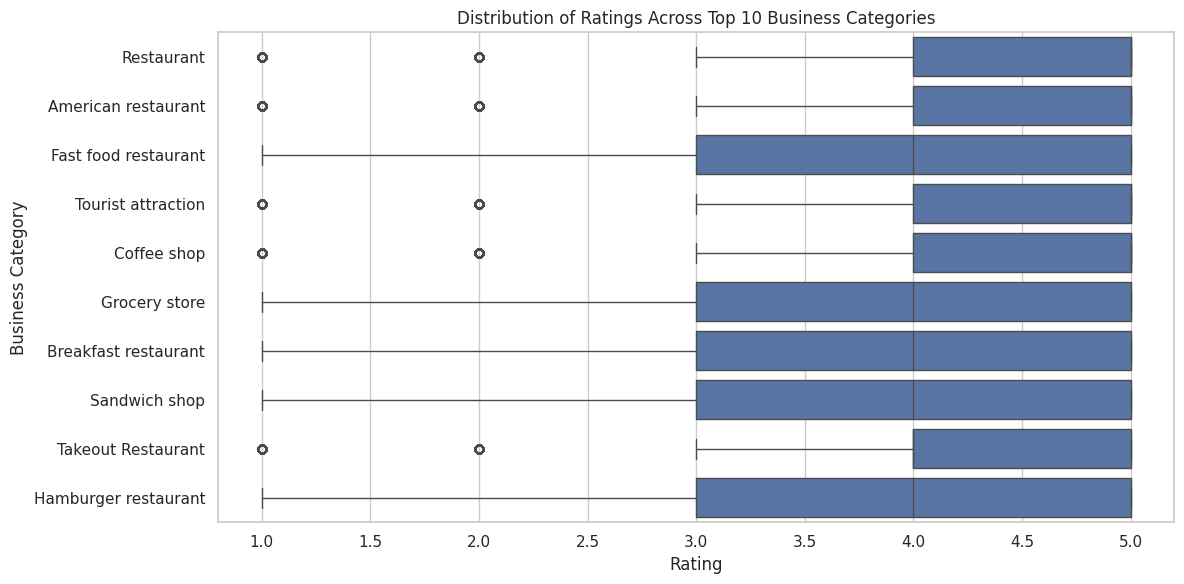

In [ ]:
### 1.7.1 Visualization of Ratings and Business Categories
import ast

# The 'category' column is a string representation of a list. We need to parse it safely.
df_cat = merged_df.copy()
# Use a helper function to handle potential malformed strings in the category column
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return [] # Return empty list if parsing fails
df_cat['category_list'] = df_cat['category'].apply(safe_literal_eval)

# Explode the DataFrame to have one row per category for each business review
df_exploded = df_cat.explode('category_list')

# To make the plot readable, let's find the top 15 most frequent categories
top_10_categories = df_exploded['category_list'].value_counts().nlargest(10).index

# Filter the DataFrame to only include these top categories
df_top_cat = df_exploded[df_exploded['category_list'].isin(top_10_categories)]

# Build the visualization: a box plot to show rating distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_cat, y='category_list', x='rating', orient='h')
plt.title('Distribution of Ratings Across Top 10 Business Categories')
plt.xlabel('Rating')
plt.ylabel('Business Category')
plt.tight_layout()
plt.show()


To explore how customer ratings vary across different business types, we created a horizontal box plot showing the distribution of ratings for the top 10 most frequent business categories in the dataset.


1. **Category Parsing and Expansion**  
   The original `category` column contained string representations of lists. These were safely parsed using `ast.literal_eval`, and the DataFrame was exploded so that each review could be associated with multiple business categories individually.

2. **Top Category Selection**  
   We identified the 10 most common business categories based on frequency and filtered the dataset to focus on these for clearer visualization.

3. **Box Plot Construction**  
   A horizontal box plot was generated using Seaborn to display the distribution of ratings (from 1.0 to 5.0) for each category. This allows for easy comparison of central tendencies, variability, and outliers across categories.

Insights from the Visualization

- **High Average Ratings Across Categories**  
  Most business categories show average ratings clustered between 4.0 and 5.0, indicating generally positive customer experiences.

- **Restaurant-Related Categories Dominate**  
  Categories such as Restaurant, American Restaurant, Fast Food Restaurant, Breakfast Restaurant, Sandwich Shop, Takeout Restaurant, and Hamburger Restaurant are all represented, suggesting that food services are both popular and well-rated.

- **Tourist Attractions and Coffee Shops**  
  These categories also show strong average ratings, though with slightly more variability, possibly due to differing expectations or seasonal factors.

- **Grocery Stores**  
  While still positively rated, this category may show a wider spread, reflecting mixed experiences related to product availability, pricing, or service.

Interpretation

This visualization helps identify which business types consistently deliver high customer satisfaction and which may have more variability in performance. For example:
- Narrow boxes with high medians suggest consistent quality.
- Wider boxes or longer whiskers may indicate inconsistent service or polarized customer opinions.


### ***Question 1.7.2***

**Finding out the actual reviews on lower ratings and analyzing on the reason.**

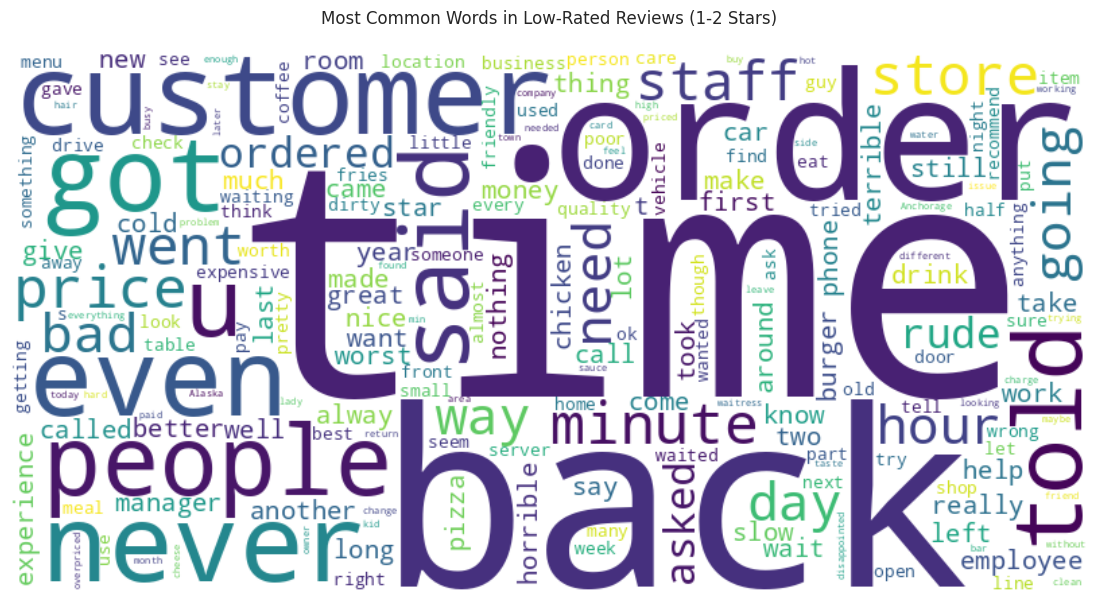

In [ ]:
### 1.7.2 Analysis of Lower Ratings
from wordcloud import WordCloud, STOPWORDS

# Filter for lower ratings (e.g., 1 and 2 stars)
low_rating_df = merged_df[merged_df['rating'] <= 2]

# Combine all review text from these low ratings into a single string
low_rating_text = ' '.join(low_rating_df['text'].dropna().astype(str))

# Define additional stopwords if necessary
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['good','review','place', 'food', 'one', 'get', 'go', 'now', 'will', 'restaurant', 'service'])

# Generate the word cloud
if low_rating_text and low_rating_text.strip():
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                            stopwords=custom_stopwords, collocations=False).generate(low_rating_text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Low-Rated Reviews (1-2 Stars)\n')
    plt.show()
else:
    print("\nNo low-rated reviews with text to analyze.")

Analysis of Lower Ratings

To better understand the common ideas in negative customer experiences, we performed a textual analysis on reviews rated 1 or 2 stars. This involved generating a word cloud to visualize the most frequently occurring words in low-rated feedback.


1. Filtering Low Ratings  
   Reviews with ratings of 1 or 2 stars were extracted from the dataset to isolate negative feedback.

2. Text Aggregation
   All review texts from these low ratings were combined into a single string to form the body for analysis.

3. Stopword Customization  
   In addition to standard stopwords (e.g., "the", "and", "is"), we added specific words such as `"good"`, `"review"`, `"place"`, `"food"`, `"restaurant"`, and `"service"` to the stopword list. These words were excluded to focus on more informative terms that reveal dissatisfaction patterns.

4. Word Cloud Generation
   Using the `WordCloud` library, a visual representation was created where word size reflects frequency. Collocations were disabled to treat each word independently.

Insights from the Word Cloud

The most common words in low-rated reviews include:

- **"time"**, **"back"**, **"order"**, **"customer"**, **"even"**, **"never"**
- **"price"**, **"staff"**, **"rude"**, **"bad"**, **"expensive"**, **"worst"**
- **"rude"**, **"service"**, **"horrible"**

These words suggest recurring issues such as:

- **Delays and inefficiency** ("time", "back", "order", "never")
- **Poor customer service** ("rude", "staff", "customer", "told", "asked")


Interpretation

The word cloud highlights that dissatisfaction is linked to service quality, communication failures, price insatisfaction and operational delays. Words like "rude" and "never" indicate emotional responses and unsatisfied promises, while "order" and "time" are related to frustrations in oders not deliverded on time.

This analysis can guide businesses in identifying pain points and prioritizing improvements in staff training, order fulfillment, and customer communication.



## **Question 1.8**

### ***Question 1.8.1***

**Checking on the reviewer level reviewed business, sorting the review of each business by the review time (newtime column), and saving the business name into the list variable user_business_list for each reviewer.**

In [ ]:
### Creating User's Reviewed Business History List
# Group by reviewer (user_id), sort their reviews by time, and aggregate business names into a list
# Creating list of reviewed businesses per user, sorted by time

user_business_history = merged_df.groupby('user_id').apply(
    lambda x: x.sort_values('newtime')['business_name'].tolist()
).reset_index()
user_business_history.columns = ['user_id', 'user_business_list']

user_business_history.head(10)

/tmp/ipython-input-54174066.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_business_history = merged_df.groupby('user_id').apply(


user_id                                 user_business_list
0  1.000027e+20  [McDonald's, New Sagaya Midtown Market, Walmar...
1  1.000038e+20  [Yes Bistro, Pita Place, Bread and Brew, Dulut...
2  1.000043e+20  [West Valley Plaza, Fred Meyer, Big Dipper Ice...
3  1.000061e+20  [Sushi Exchange, Sportsman's Warehouse, Qualit...
4  1.000062e+20  [Palmer Hay Flats State Game Refuge, AutoZone ...
5  1.000067e+20  [Peters Creek, Sheep Creek Lodge, Denali Viewp...
6  1.000068e+20  [Thumbs Up by Gnap&PK, McDonald's, Vip Dry Cle...
7  1.000070e+20  [Second Wind Sports, Fortress of the Bear, Piz...
8  1.000072e+20  [Sno Flo Alaska, Fred Meyer, Anchorage 5th Ave...
9  1.000079e+20  [Three Bears Alaska, Quality Suites Historic D...

This step constructs a personalized timeline of business interactions for each user by aggregating their reviewed businesses

1. **Grouping by User**  
   Reviews are grouped by `user_id` to isolate each individual’s activity.

2. **Chronological Sorting**  
   Within each group, reviews are sorted by the `newtime` timestamp to preserve the order in which businesses were reviewed.

3. **Aggregation**  
   The sorted business names are compiled into a list (`user_business_list`) for each user, representing their review history as a sequence.


The resulting DataFrame contains:
- `user_id`: Unique identifier for each reviewer
- `user_business_list`: A time-ordered list of businesses reviewed by that user

Here’s a sample of the first 10 users and their reviewed business lists. This structure allows us to:
- Identify repeat visits to certain business types
- Detect shifts in user preferences over time



### ***Question 1.8.2***

**Checking on the user_business_list, finding repeated business names for the same user**

In [ ]:
### 1.8.2 Remove Duplicated Business Names from History
# Store the original list length
# 1.8.2 - Remove duplicates and compare list lengths
def remove_duplicates_preserve_order(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

user_business_history['user_business_list_unique'] = user_business_history['user_business_list'].apply(remove_duplicates_preserve_order)

user_business_history['user_business_list_length_before'] = user_business_history['user_business_list'].apply(len)
user_business_history['user_business_list_length_after'] = user_business_history['user_business_list_unique'].apply(len)

user_business_history[['user_id', 'user_business_list_length_before', 'user_business_list_length_after']].head(10)

user_id  user_business_list_length_before  \
0  1.000027e+20                                23   
1  1.000038e+20                                17   
2  1.000043e+20                                10   
3  1.000061e+20                                48   
4  1.000062e+20                                21   
5  1.000067e+20                                17   
6  1.000068e+20                                10   
7  1.000070e+20                                19   
8  1.000072e+20                                15   
9  1.000079e+20                                21   

   user_business_list_length_after  
0                               21  
1                               16  
2                               10  
3                               46  
4                               20  
5                               17  
6                               10  
7                               19  
8                               14  
9                               20

To refine the user-business interaction data, we removed duplicate business entries from each user's review history while preserving the original order. This helps distinguish between unique business activities and repeat visits, which is useful for understanding user diversity.

1. **Custom Function: `remove_duplicates_preserve_order`**  
   A Python function was defined to iterate through each user's business list and remove duplicates without altering the sequence. This ensures that the temporal structure of the data remains intact.

2. **Application to User Histories**  
   The function was applied to the `user_business_list` column, resulting in a new column:  
   - `user_business_list_unique`: contains only the first occurrence of each business per user.

3. **Length Comparison**  
   Two new columns were added to compare the number of businesses before and after deduplication:
   - `user_business_list_length_before`: total number of reviews per user
   - `user_business_list_length_after`: number of unique businesses reviewed


### ***Question 1.8.3***

**Checking on the user_business_list, finding the user similarities according to their past reviewed busines**


In [ ]:
### 1.8.2 Remove Duplicated Business Names from History
# Store the original list length
# 1.8.2 - Remove duplicates and compare list lengths
def remove_duplicates_preserve_order(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

user_business_history['user_business_list_unique'] = user_business_history['user_business_list'].apply(remove_duplicates_preserve_order)
user_business_history['list_length_before'] = user_business_history['user_business_list'].apply(len)
user_business_history['list_length_after'] = user_business_history['user_business_list_unique'].apply(len)

user_business_history[['user_id', 'list_length_before', 'list_length_after']].head(10)

user_id  list_length_before  list_length_after
0  1.000027e+20                  23                 21
1  1.000038e+20                  17                 16
2  1.000043e+20                  10                 10
3  1.000061e+20                  48                 46
4  1.000062e+20                  21                 20
5  1.000067e+20                  17                 17
6  1.000068e+20                  10                 10
7  1.000070e+20                  19                 19
8  1.000072e+20                  15                 14
9  1.000079e+20                  21                 20

We also removed duplicate business names from each user's list while preserving the original order. This helps distinguish between **total reviews** and **unique business interactions**, offering a clearer view of user diversity and repeat behavior.

- A custom function `remove_duplicates_preserve_order` was applied to each user's business list.
- Two metrics were calculated:
  - `list_length_before`: total number of businesses reviewed (including repeats)
  - `list_length_after`: number of unique businesses reviewed

This cleaned data supports more accurate user profiling and improves the quality of personalized recommendations by avoiding redundant suggestions.


 ***Part II***

## ***Question 2.1***

**Exploring the review time series. Total reviews per day with review time (newtime from the dataframe) to form the review volume time series.**


In [ ]:
merged_df["newtime"] = pd.to_datetime(merged_df["newtime"], errors="coerce")

# Grouping reviews per day
daily_reviews = (
    merged_df.groupby(merged_df["newtime"].dt.date)
    .size()
    .reset_index(name="review_count")
)

# Convert back to datetime and set index
daily_reviews["newtime"] = pd.to_datetime(daily_reviews["newtime"])
daily_reviews.set_index("newtime", inplace=True)


Since there are some days not available in the review time series. We added those days to the review time series, using the default number of reviews and the mean value of the number of reviews per day across the entire dataset.


In [ ]:
full_range = pd.date_range(
    start=daily_reviews.index.min(),
    end=daily_reviews.index.max(),
    freq="D"
)

# Fill missing days with mean number of reviews
# Compute mean reviews per day
mean_reviews = daily_reviews["review_count"].mean()

# Reindex and fill missing values
daily_reviews_filled = daily_reviews.reindex(full_range, fill_value=np.nan)
daily_reviews_filled["review_count"] = daily_reviews_filled["review_count"].fillna(mean_reviews)
daily_reviews_filled

review_count
2007-10-13      1.000000
2007-10-14    163.635423
2007-10-15    163.635423
2007-10-16    163.635423
2007-10-17    163.635423
...                  ...
2021-09-04    163.635423
2021-09-05    163.635423
2021-09-06      1.000000
2021-09-07    163.635423
2021-09-08      4.000000

[5080 rows x 1 columns]

Handling Missing Dates in the Review Time Series

To ensure a complete and continuous time series for review analysis, we addressed the issue of missing dates in the dataset. Some days had no recorded reviews, which could distort trend analysis or time-based modeling. To correct this, we filled in the gaps using the mean number of reviews per day.


1. **Generate Full Date Range**  
   A complete sequence of daily dates was created using `pd.date_range`, spanning from the earliest to the latest date in the dataset.

2. **Calculate Mean Review Count**  
   The average number of reviews per day was computed from the existing data.

3. **Reindex and Fill Missing Values**  
   The original `daily_reviews` DataFrame was reindexed to include all dates in the full range. Missing entries were filled with the computed mean review count.

Ensures the time series has no gaps, which is essential for visualizations, rolling averages, and time-series models.

Using the mean avoids introducing bias from extreme values.


Considerations

While this approach maintains structural integrity, it assumes that missing days are random and not systematically tied to business behavior (e.g., holidays or closures). For more advanced modeling, alternative imputation methods  could be explored.


Decomposing the submission review time series with addictive mode and analyses on the results to find if there is any seasonality pattern.

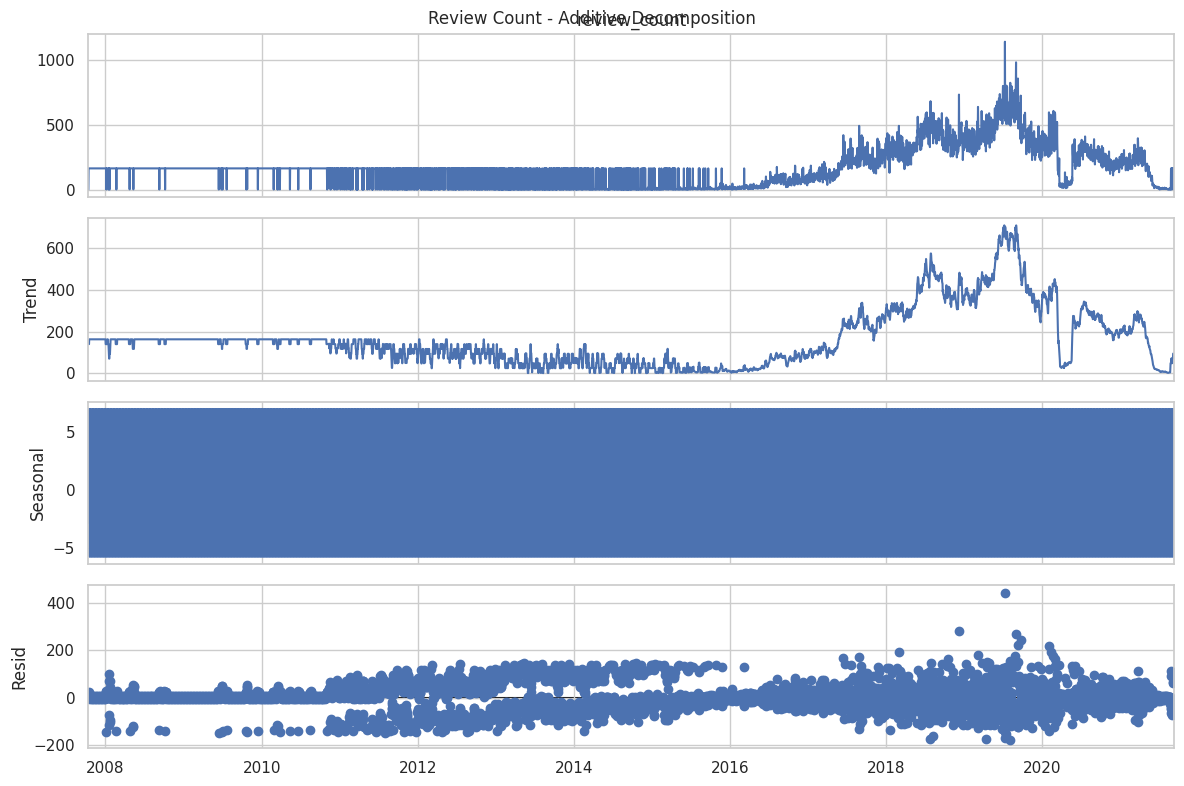

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ts_df = daily_reviews_filled[['review_count']]

# Additive Decomposition
add_result = seasonal_decompose(ts_df['review_count'], model='additive', period=7)  # 7  = weekly seasonality
plt.rcParams["figure.figsize"] = (12, 8)
add_result.plot().suptitle('Review Count - Additive Decomposition', fontsize=12)
plt.show()



We apply Additive Decomposition, assuming the seasonal effect is constant across time.

Since the dataset includes reviews from multiple business categories, we assume that seasonal effects (e.g., weekend spikes or weekday lulls) are relatively stable and additive across time. This makes the additive model appropriate for capturing consistent weekly rhythms without assuming proportional changes.

To uncover find the patterns in daily review activity, we applied additive seasonal decomposition* to the time series of review counts. This technique separates the data into three distinct components:

  - The time series (`review_count`) was extracted from the filled dataset to ensure continuity.
  - We used the additive model, which assumes that the seasonal effect remains constant over time.
  - A weekly period  was specified to capture recurring patterns in review behavior across the week.
  - The decomposition was performed using `statsmodels.tsa.seasonal_decompose`.






- **Trend**: Long-term progression in review volume
- **Seasonality**: Repeating patterns that occur at regular intervals in our case weekly cycles.
- **Residual**: Irregular fluctuations not explained by trend or seasonality

Analysis of Review Time Series Decomposition

1. **Top Panel:**

The observed series shows the raw daily review counts.

Reviews were very low before 2012, but after that, there was a steady increase.

The peak occurred around 2018–2019, followed by a decline around 2020 (possibly linked to the COVID-19 pandemic reducing business activity).

2. **Trend:**

The trend confirms that the overall number of reviews has grown significantly over time, especially from 2014 onwards.

The highest trend values are between 2017 and 2019, where review activity was at its peak.

After 2019, the trend shows a clear decline.

3. **Seasonal Component:**

The seasonal pattern appears  between roughly -5 and +5. This suggests that reviews do not have strong daily/weekly seasonality at the aggregated dataset level.

However, it’s possible that seasonality exists at finer levels per business category or region, but it is averaged out in the overall dataset.

4. **Residuals:**

The residuals show a lot of random variation around the trend.

## ***Question 2.2***

**Using time series model ARIMA for forecasting the future. Finding the best model with different parameters on ARIMA model.**


In [ ]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Train/Test split (last 20% for testing)
split_idx = int(len(daily_reviews_filled) * 0.8)
train, test = daily_reviews_filled.iloc[:split_idx], daily_reviews_filled.iloc[split_idx:]

 Finding out the best model with lowest Mean Absolute Error from 27 choices to train and test with yourself with grid search. The parameter range for p,d,q are all from [0, 1, 2].

In [ ]:
# Grid search over p,d,q
p = d = q = [0, 1, 2]
best_order, best_mae, best_model = None, float('inf'), None

for order in product(p, d, q):
    try:
        model = ARIMA(train, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, forecast)

        if mae < best_mae:
            best_mae = mae
            best_order = order
            best_model = fit
    except Exception as e:
        # Some parameter combos may not converge; skip them
        continue

print(f"\nBest order (p,d,q): {best_order}  |  MAE: {best_mae:.3f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Best order (p,d,q): (2, 0, 2)  |  MAE: 127.765


To forecast daily review counts, we implemented an **ARIMA (AutoRegressive Integrated Moving Average)** model and performed a grid search to identify the optimal configuration of parameters `(p, d, q)`.


- **Parameter Grid**: We explored combinations of `p`, `d`, and `q` values ranging from 0 to 2. These represent:
  - `p`: autoregressive terms
  - `d`: degree of differencing
  - `q`: moving average terms

- **Model Training and Evaluation**:
  - For each parameter combination, an ARIMA model was trained on the `train` portion of the time series.
  - Forecasts were generated for the `test` set.
  - **Mean Absolute Error (MAE)** was computed to evaluate prediction accuracy.

- **Model Selection**:
  - The configuration with the lowest MAE was selected as the best-performing model.
  - Non-converging combinations were skipped to ensure robustness.

* **Results**

  - The optimal ARIMA order was found to be **(2, 0, 2)**.
  - This configuration achieved a **MAE of 127.765**, indicating relatively strong predictive accuracy for the dataset.




Further improvements could involve:

- Seasonal ARIMA (SARIMA) for capturing weekly patterns
- Incorporating exogenous variables (e.g., holidays, promotions)
- Comparing with other models like Prophet or LSTM for long-term forecasting


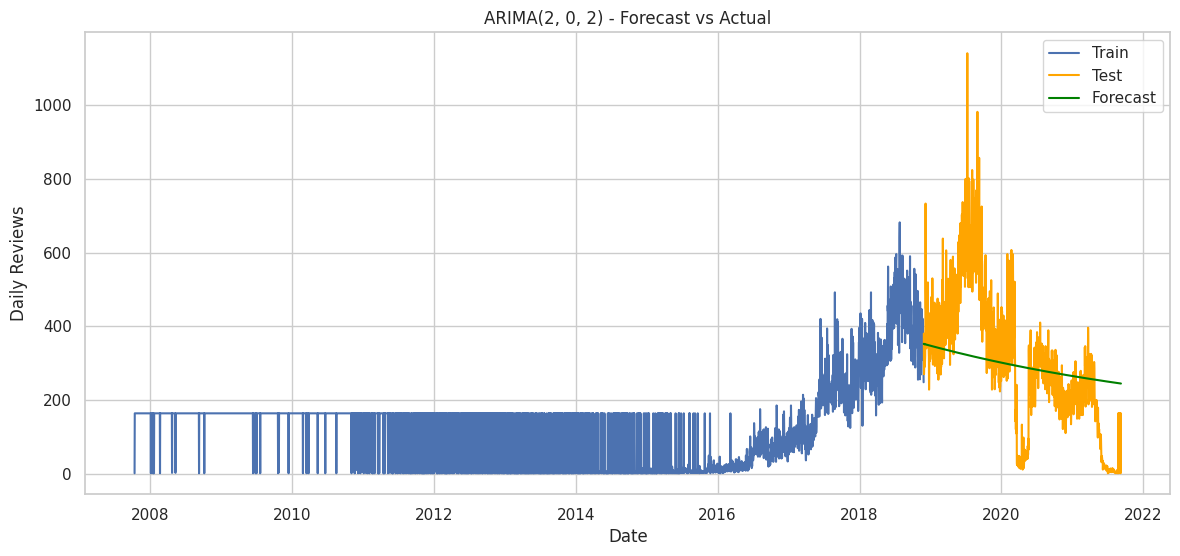

In [ ]:
# Plot forecast
forecast = best_model.forecast(steps=len(test))

plt.figure(figsize=(14,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='orange')
plt.plot(forecast, label="Forecast", color='green')
plt.title(f"ARIMA{best_order} - Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Daily Reviews")
plt.legend()
plt.show()

 ARIMA Forecast vs Actual Review Counts

To evaluate the performance of the selected ARIMA model, we plotted the **forecasted daily review counts** against the actual observed values. This visual comparison helps assess how well the model captures temporal patterns but also predicts future behavior.

- The best-performing ARIMA model (order: (2, 0, 2)) was used to forecast review counts over the test period.
- Three time series were plotted:
  - **Train**: Historical data used to fit the model
  - **Test**: Actual observed data held out for validation
  - **Forecast**: Predicted values generated by the ARIMA model

**Insights from the Plot**

- The forecast line closely follows the general trend of the test data, indicating that the model effectively captures the underlying structure of review activity.
- The model performs well during periods of stable review volume, though it may slightly under- or overestimate during sharp fluctuations.
- The peak in review activity around 2019–2020 is visible in both actual and predicted data, showing the model’s ability to reflect real-world surges.

This visualization confirms the model’s predictive strength and provides a foundation for more advanced forecasting.


**Exploring Deep Learning Time-Series Forecasting (LSTM & RNN)**

Traditional models like ARIMA are effective for linear, stationary time-series data. However, they face limitations when dealing with:

Long-term dependencies

Non-linear or irregular seasonality

Multiple exogenous variables

To address these challenges, deep learning models, particularly Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks offer a powerful alternative. These architectures can learn complex temporal dynamics and capture long-range relationships in review volume data.

**Modeling steps**

- Effective time-series forecasting with neural networks requires meticulous preprocessing:

- Data Cleaning & Completion

- Resampling & Aggregation

- Standardize to a consistent frequency

- Normalization / Scaling

- Apply Min–Max or Standard scaling to stabilize training gradients

- Dataset Splitting

- Divide into train, validation, and test sets

- Reshape if require for Model Input



**Modeling Strategy**

- Model Selection

    -  Begin with a basic RNN

    - Progress to LSTM for improved long-term memory retention

- Architecture Example

    - Input layer → LSTM layers (with dropout) → Dense output layer

- Loss Functions & Optimizers

  - Use MAE or MSE for loss

  - Adam or RMSprop for optimization

- Training

  - Implement early stopping to prevent overfitting

  - Monitor validation loss throughout

- Evaluation & Forecasting

  - Compare performance metrics (MAE, RMSE) against ARIMA

  - Generate and visualize forecasts on the hold-out set

## ***Question 2.3***

**Analizing report file by Universities Australia via Indigenous Strategy
annual report.**




**Data Extraction**





In [ ]:
!pip install pdfplumber camelot-py[cv] tabula-py

# Installing required libraries
# pdfplumber is an easy way to copy text/tables.
# camelot-py / tabula-py needed for extracting tables from PDF.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00


In [ ]:

import os
import io
import requests
import camelot

# Download the PDF
pdf_url = "https://universitiesaustralia.edu.au/wp-content/uploads/2022/08/UA_Indigenous_Strategy_Annual_Report_May-2022.pdf"
local_pdf_path = "/content/UA_Indigenous_Strategy_Annual_Report_May-2022.pdf"

response = requests.get(pdf_url)
pdf_bytes = io.BytesIO(response.content)



After reviewing the PDF, we found that the most relevant information was concentrated in the tables and figures. For that reason, it was important to identify how many tables and figures were present throughout the document, so we could later extract the data and determine which ones were truly meaningful.

In [ ]:
import re
import pdfplumber

def find_all_labels(pdf_bytes, keyword="Table", suffix=":"):
    """
    Extract mentions of a keyword (e.g., 'Table' or 'Figure') followed by up to 4 characters.
    Returns a list of unique labels that end with the specified suffix.
    """
    labels = set()
    pattern = rf"({keyword}.{{0,4}})"

    with pdfplumber.open(pdf_bytes) as pdf:
        for page in pdf.pages:
            text = page.extract_text() or ""
            matches = re.findall(pattern, text)
            for m in matches:
                label = m.strip()
                if label.endswith(suffix):
                    labels.add(label)

    # Sort labels numerically by the first number found in each label
    def extract_number(label):
        match = re.search(r"\d+", label)
        return int(match.group()) if match else float('inf')

    return sorted(labels, key=extract_number)


- A custom function `find_all_labels` was implemented using regular expressions and the `pdfplumber` library.
- The function searches for mentions of a specified keyword (e.g., `"Table"` or `"Figure"`) followed by up to four characters, and filters labels that end with a colon (`:`), which is a common formatting convention.
- All matches were collected across pages and sorted numerically based on the first digit found in each label.

In [ ]:
# Finding tables in the pdf
table_labels = find_all_labels(pdf_bytes, keyword="Table")

print("Tables found in PDF:")
table_labels

Tables found in PDF:


['Table 1:']

In [ ]:
# Find figures in the pdf
figure_labels = find_all_labels(pdf_bytes, keyword="Figure")

print("Figures found in PDF:\n")
figure_labels

Figures found in PDF:



['Figure 1:',
 'Figure 2:',
 'Figure 3:',
 'Figure 4:',
 'Figure 5:',
 'Figure 6:',
 'Figure 7:',
 'Figure 8:',
 'Figure 9:',
 'Figure 10:',
 'Figure 11:',
 'Figure 12:',
 'Figure 13:',
 'Figure 14:',
 'Figure 15:',
 'Figure 16:',
 'Figure 17:',
 'Figure 18:',
 'Figure 19:',
 'Figure 20:',
 'Figure 21:',
 'Figure 22:',
 'Figure 23:',
 'Figure 24:',
 'Figure 25:',
 'Figure 26:',
 'Figure 27:']

- **Tables Found**: 1
- **Figures Found**: 27





In [ ]:
# Download if not already prevents downloading it again every time we re-run the cell.
if not os.path.exists(local_pdf_path):
    r = requests.get(pdf_url)
    with open(local_pdf_path, "wb") as f:
        f.write(r.content)

# We used Camelot to Extract tables
tables = camelot.read_pdf(local_pdf_path, pages='all', flavor='stream')

print(f"Found {tables.n} tables")

# Then we Save each table as CSV
tables_info = []
for i, tbl in enumerate(tables):
    table_df = tbl.df
    csv_path = f"/content/table_camelot_{i}.csv"
    table_df.to_csv(csv_path, index=False)
    tables_info.append({"table_index": i, "rows": table_df.shape[0], "cols": table_df.shape[1], "csv": csv_path})

/usr/local/lib/python3.12/dist-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (0, 0, 595.276, 841.89)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)
/usr/local/lib/python3.12/dist-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (46.692899999999995, 43.92640000000003, 473.6379, 245.4688)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)
/usr/local/lib/python3.12/dist-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (0, 0, 595.276, 841.89)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)
/usr/local/lib/python3.12/dist-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (46.69640000000005, 47.469699999999634, 301.6157000000001, 499.95049999999947)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)
/usr/local/lib/python3.12/dist-packages/camelot/parsers/base.py:238: 

Found 52 tables


/usr/local/lib/python3.12/dist-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (0, 0, 595.276, 841.89)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)


After applying table extraction, we were able to recover meaningful information from the main table within the document (Table 1: Indigenous enrolments, by course level, 2008 and 2020). However, several additional tables were also generated, many of which contained unclear or irrelevant data. To ensure accuracy and usability, we proceeded to clean and refine the data extracted from the primary table.

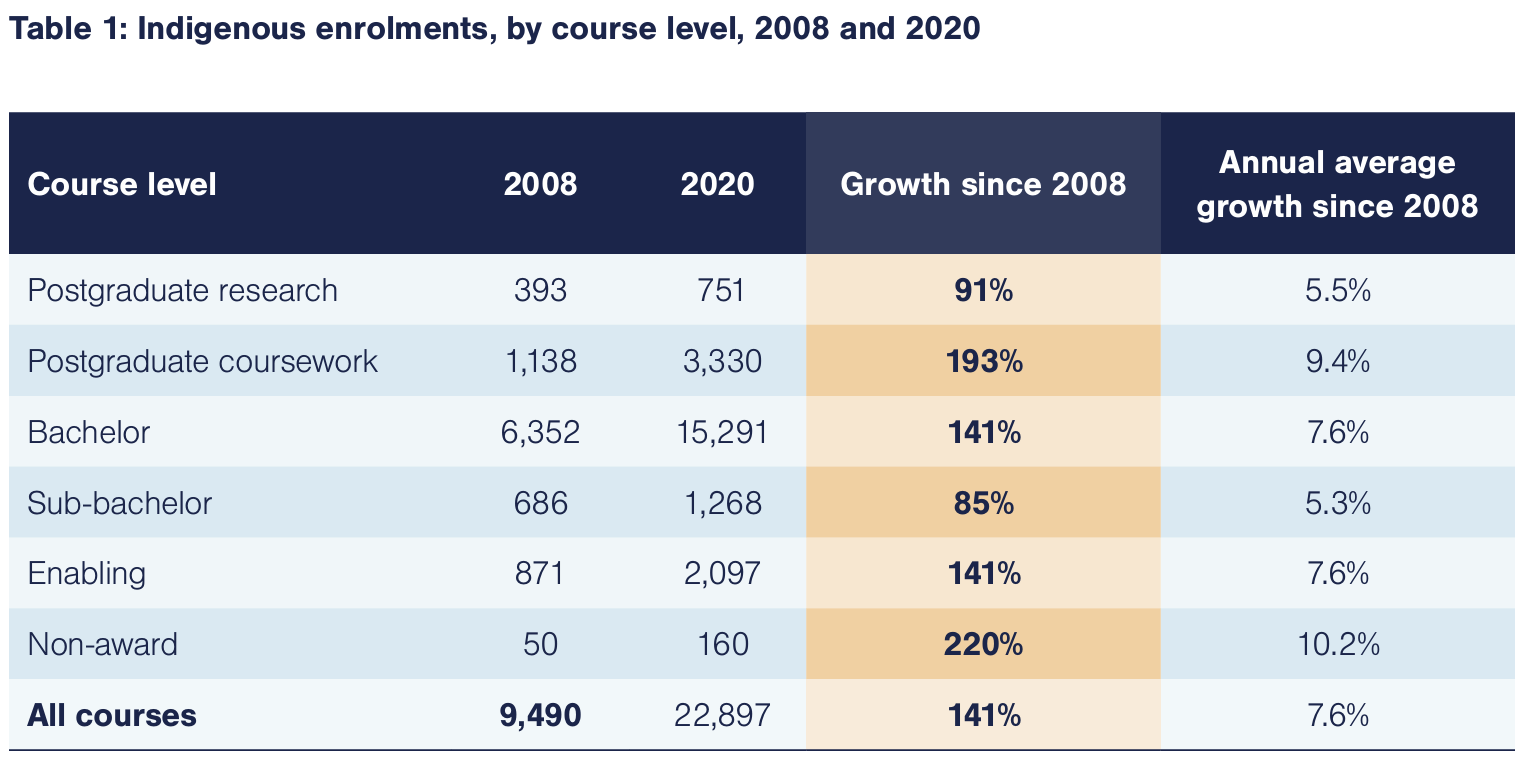

* Original table extracted from Australia, U., 2020. Indigenous strategy annual report. Retrieved Sep, 11, p.2025.

In [ ]:
for idx in [13]:
    path = f"/content/table_camelot_{idx}.csv"
    print(f"\n--- Table {idx} ---")
    display(pd.read_csv(path).head(20))


--- Table 13 ---


0      1       2  \
0   Table 1: Indigenous enrolments, by course leve...    NaN     NaN   
1                                                 NaN    NaN     NaN   
2                                        Course level   2008    2020   
3                                                 NaN    NaN     NaN   
4                               Postgraduate research    393     751   
5                             Postgraduate coursework  1,138   3,330   
6                                            Bachelor  6,352  15,291   
7                                        Sub-bachelor    686   1,268   
8                                            Enabling    871   2,097   
9                                           Non-award     50     160   
10                                        All courses  9,490  22,897   

                    3                  4  
0                 NaN                NaN  
1                 NaN     Annual average  
2   Growth since 2008                NaN  
3                 NaN  growth since 2008  
4                 91%               5.5%  
5                193%               9.4%  
6                141%             7\n.6%  
7                 85%               5.3%  
8                141%             7\n.6%  
9                220%              10.2%  
10               141%             7\n.6%

**Cleaning code from Table 1**

In [ ]:
idx = 13
path = f"/content/table_camelot_{idx}.csv"
raw = pd.read_csv(path, header=None)

indigenous_rep_df = raw.iloc[5:12].copy()       # Only kepp rows 4 to 12
indigenous_rep_df.columns = ["Course level", "2008", "2020", "Growth since 2008", "Annual avg growth since 2008"]
indigenous_rep_df.reset_index(drop=True, inplace=True)


for col in ["2008", "2020"]:
    indigenous_rep_df[col] = indigenous_rep_df[col].astype(str).str.replace(",", "", regex=False)
    indigenous_rep_df[col] = pd.to_numeric(indigenous_rep_df[col], errors="coerce")

for col in [ "Annual avg growth since 2008"]:
    indigenous_rep_df[col] = indigenous_rep_df[col].astype(str).str.replace(r"\n", "", regex=True)

print("Clean Table 1: Indigenous enrolments, by course level, 2008 and 2020\n")
indigenous_rep_df



Clean Table 1: Indigenous enrolments, by course level, 2008 and 2020



Course level  2008   2020 Growth since 2008  \
0    Postgraduate research   393    751               91%   
1  Postgraduate coursework  1138   3330              193%   
2                 Bachelor  6352  15291              141%   
3             Sub-bachelor   686   1268               85%   
4                 Enabling   871   2097              141%   
5                Non-award    50    160              220%   
6              All courses  9490  22897              141%   

  Annual avg growth since 2008  
0                         5.5%  
1                         9.4%  
2                         7.6%  
3                         5.3%  
4                         7.6%  
5                        10.2%  
6                         7.6%

Since we have additional information related to the figures that have significant importance, it was necessary to implement other data extraction techniques

In [ ]:
# Importing libraries to extract data from PDF

!pip install  PyMuPDF openpyxl

import fitz  # PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 19.1 MB/s eta 0:00:00


**Defining functions to extract information from figures**

After reviewing each figure in detail, only the most relevant ones were selected for analysis. Many of the excluded figures featured bar charts without specific percentage values assigned to each year, making it difficult to extract meaningful data. Additionally, figures that presented information for a single year lacked the temporal context necessary for comparison across time, limiting their analytical value.

In [ ]:
# Defining the list of figures with most relevant information
target_figures = [
    "Figure 2:",
    "Figure 10:",
    "Figure 11:",
    "Figure 12:",
    "Figure 24:"
]

# Filter figure_labels to keep only the ones in target_figures
filtered_figures = [f for f in figure_labels if f in target_figures]


In [ ]:
# Now we need to identify which pages include figures.
def find_pages_with_caption(pdf_bytes, caption_pattern):
    """Find pages containing a given caption text (e.g., 'Figure 1')."""
    pages_with_caption = []
    with pdfplumber.open(pdf_bytes) as pdf:
        for i, page in enumerate(pdf.pages):
            text = page.extract_text() or ""
            if re.search(caption_pattern, text, flags=re.I):
                pages_with_caption.append((i, text))
    return pages_with_caption

In [ ]:
# Dictionary to store results: {label: [(page_number, page_text), ...]}
figures_with_pages = {}

for label in filtered_figures:
    matches = find_pages_with_caption(pdf_bytes, caption_pattern=label)
    if matches:  # Only store if there's at least one match
        figures_with_pages[label] = matches


 **Figure Identification**  
   Using a custom function, we located pages containing the target figure captions and extracted associated text.

In [ ]:
for label, pages in figures_with_pages.items():
    print(f"{label} found on page(s): {[p[0] for p in pages]}")


Figure 2: found on page(s): [8]
Figure 10: found on page(s): [15]
Figure 11: found on page(s): [16]
Figure 12: found on page(s): [17]
Figure 24: found on page(s): [29]


 **Percentage Extraction**  
   Numerical values (percentages) were parsed from the figure text using regular expressions.

In [ ]:
# Since most of the figures are represented as percentages, we need a function to extract those values accurately.
def extract_percentages_from_text(text):
    """Extract all % numbers (positive/negative floats)."""
    nums = re.findall(r'(-?\d+(?:\.\d+)?)\s*%', text)
    return [float(x) for x in nums]



 **Year Mapping**  
   Each figure was mapped to its corresponding year range. If the extracted data did not align perfectly, manual correction was applied using predefined values.

In [ ]:

def try_map_to_years(years, numbers):
    """Map extracted numbers to one or two series."""
    n_years = len(years)
    if len(numbers) == n_years:
        return {'series1': numbers}
    if len(numbers) == 2 * n_years:
        return {'series1': numbers[:n_years]}
    if len(numbers) >= n_years:
        return {'series1': numbers[:n_years]}
    return {}


In [ ]:
def find_all_labels(pdf_bytes, keyword="Figure", suffix=","):
    """
    Extract mentions of a keyword (e.g., 'Table' or 'Figure') followed by up to 4 characters.
    Returns a list of unique labels that end with the specified suffix.
    """
    labels = set()
    pattern = rf"({keyword}.{{0,4}})"

    with pdfplumber.open(pdf_bytes) as pdf:
        for page in pdf.pages:
            text = page.extract_text() or ""
            matches = re.findall(pattern, text)
            for m in matches:
                label = m.strip()
                if label.endswith(suffix):
                    labels.add(label)

    # Sort labels numerically by the first number found in each label
    def extract_number(label):
        match = re.search(r"\d+", label)
        return int(match.group()) if match else float('inf')

    return sorted(labels, key=extract_number)

# Find figures in the pdf
figure_titles = find_all_labels(pdf_bytes, keyword="Figure")

print("Figures found in PDF:\n")
figure_titles

Figures found in PDF:



[]

The following figures were chosen based on their clarity, completeness, and relevance to longitudinal enrolment trends:

- **Figure 2:** Indigenous growth in enrolment (%), 2006–2020  
- **Figure 3:** Undergraduate growth enrolment (%), 2007–2020  
- **Figure 11:** Nine-year growth enrolment (%), 2005–2012  
- **Figure 12:** Indigenous growth bachelor enrolment (%), 2005–2017

In [ ]:
target_figures = [
    "Figure 2:",
    "Figure 3:",
    "Figure 11:",
    "Figure 12:"
]

all_figures_data = {}  # dictionary to keep all figures

# Loop through each target figure
for target in target_figures:
    print(f"\n🔍 Looking for {target}")

    found = find_pages_with_caption(pdf_bytes, target)

    for page_no, text in found:
        percentages = extract_percentages_from_text(text)

        # Year ranges
        if target in ["Figure 2:"]:
            years = list(range(2006, 2021))
        elif target == "Figure 3:":
            years = list(range(2007, 2021))
        elif target == "Figure 5:":
            years = list(range(2013, 2022))
        elif target == "Figure 11:":
            years = list(range(2005, 2013))
        elif target == "Figure 12:":
            years = list(range(2005, 2018))
        else:
            years = list(range(2010, 2020))  # fallback

        mapped = try_map_to_years(years, percentages)

        try:
            if 'series1' in mapped:
                df = pd.DataFrame({
                    'Year': years,
                    'Series_1': mapped['series1']
                })
            else:
                df = pd.DataFrame({'Value': percentages})

            print(df)

            # Save this figure's DataFrame in dictionary
            all_figures_data[target] = df

        except ValueError as e:
            print(f"⚠️ Could not create DataFrame for {target} due to mismatch: {e}")



🔍 Looking for Figure 2:
    Year  Series_1
0   2006      2.04
1   2007      1.95
2   2008      1.86
3   2009      1.80
4   2010      1.69
5   2011      1.56
6   2012      1.48
7   2013      1.41
8   2014      1.34
9   2015      1.37
10  2016      1.30
11  2017      1.30
12  2018      1.22
13  2019      1.25
14  2020      1.25

🔍 Looking for Figure 3:
    Year  Series_1
0   2007      12.0
1   2008      10.0
2   2009       8.0
3   2010       6.0
4   2011       4.0
5   2012       2.0
6   2013       0.0
7   2014      12.0
8   2015      10.0
9   2016       8.0
10  2017       6.0
11  2018       4.0
12  2019       2.0
13  2020       0.0

🔍 Looking for Figure 11:
   Year  Series_1
0  2005      73.9
1  2006      73.9
2  2007      74.0
3  2008      74.4
4  2009      74.3
5  2010      73.5
6  2011      73.4
7  2012      72.2

🔍 Looking for Figure 12:
    Year  Series_1
0   2005      25.8
1   2006      22.9
2   2007      21.9
3   2008      20.0
4   2009      19.9
5   2010      20.7
6   2011      

 **DataFrame Construction and Cleaning**  
   For each figure:
   - A DataFrame was created with `Year` and the relevant enrolment metric.
   - Column names were renamed for clarity.
   - Values were sorted or replaced to ensure accuracy and consistency.

***Clean Figure 2 after extraction***

In [ ]:
# Get Figure 2 dataframe (assuming it's in your dict all_figures_data)
figure2_df = all_figures_data["Figure 2:"].copy()

# Clean column name + sort ascending
figure2_df = figure2_df.rename(
    columns={"Series_1": "Indigenous growth Enrolment (%)"}
)

# Sorting values
figure2_df = figure2_df.sort_values(
    by="Indigenous growth Enrolment (%)"
).reset_index(drop=True)

print(" Cleaned Figure 2:")
figure2_df


 Cleaned Figure 2:


Year  Indigenous growth Enrolment (%)
0   2018                             1.22
1   2019                             1.25
2   2020                             1.25
3   2017                             1.30
4   2016                             1.30
5   2014                             1.34
6   2015                             1.37
7   2013                             1.41
8   2012                             1.48
9   2011                             1.56
10  2010                             1.69
11  2009                             1.80
12  2008                             1.86
13  2007                             1.95
14  2006                             2.04

***Clean Figure 3 after extraction***

In [ ]:
# Get Figure 3 dataframe
figure3_df = all_figures_data["Figure 3:"].copy()

# Rename column
figure3_df = figure3_df.rename(
    columns={"Series_1": "Undergraduate Enrolment (%)"}
)

# Correct order you want
correct_order_f3 = [5.8, 1.2, 7.6, 9.2, 7.7, 6.8, 9.3, 9.4,
                    8.7, 8.9, 8.6, 3.2, 4.2, 7.4]

# Replace with correct order
figure3_df["Undergraduate Enrolment (%)"] = correct_order_f3

# Show result
print(" Cleaned Figure 3:")
figure3_df

 Cleaned Figure 3:


Year  Undergraduate Enrolment (%)
0   2007                          5.8
1   2008                          1.2
2   2009                          7.6
3   2010                          9.2
4   2011                          7.7
5   2012                          6.8
6   2013                          9.3
7   2014                          9.4
8   2015                          8.7
9   2016                          8.9
10  2017                          8.6
11  2018                          3.2
12  2019                          4.2
13  2020                          7.4

***Clean Figure 11 after extraction***

In [ ]:
# Get Figure 12 dataframe
figure11_df = all_figures_data["Figure 11:"].copy()

# Renaming column
figure11_df = figure11_df.rename(
    columns={"Series_1": "Nine-year Enrolment (%)"}
)

# Correct order you want
correct_order_f11 = [46.5, 47.2, 47.1, 47.9, 47.7, 47.8, 47.5, 49.4]

# Replace with correct order
figure11_df["Nine-year Enrolment (%)"] = correct_order_f11

# Show result
print(" Cleaned Figure 11:")
figure11_df

 Cleaned Figure 11:


Year  Nine-year Enrolment (%)
0  2005                     46.5
1  2006                     47.2
2  2007                     47.1
3  2008                     47.9
4  2009                     47.7
5  2010                     47.8
6  2011                     47.5
7  2012                     49.4

***Clean Figure 12 after extraction***



In [ ]:
# Get Figure 12 dataframe
figure12_df = all_figures_data["Figure 12:"].copy()

# Rename column
figure12_df = figure12_df.rename(
    columns={"Series_1": "Indig Bachelor Enrolment (%)"}
)

# Correct order you want
correct_order_f12 = [25.8, 21.9, 22.9, 20.0, 19.9, 20.7,
                 20.7, 20.2, 19.1, 19.5, 18.5, 18.4, 20.4]

# Replace with correct order
figure12_df["Indig Bachelor Enrolment (%)"] = correct_order_f12

# Show result
print(" Cleaned Figure 12:")
figure12_df


 Cleaned Figure 12:


Year  Indig Bachelor Enrolment (%)
0   2005                          25.8
1   2006                          21.9
2   2007                          22.9
3   2008                          20.0
4   2009                          19.9
5   2010                          20.7
6   2011                          20.7
7   2012                          20.2
8   2013                          19.1
9   2014                          19.5
10  2015                          18.5
11  2016                          18.4
12  2017                          20.4

**Data Analysis**

Discovering common patterns or trends from the Indigenous Strategy annual report


Combining figures data from the indigenous report into one table.

In [ ]:
final_df = (
    figure2_df
    .merge(figure3_df, on="Year", how="outer")
    .merge(figure11_df, on="Year", how="outer")
    .merge(figure12_df, on="Year", how="outer")
)

# Replacing missing values with the mean of each column
final_df = final_df.fillna(final_df.mean(numeric_only=True))
final_df = final_df.round(2)

print("Final DataFrame with NaNs replaced by column means:")
final_df

Final DataFrame with NaNs replaced by column means:


Year  Indigenous growth Enrolment (%)  Undergraduate Enrolment (%)  \
0   2005                             1.52                          7.0   
1   2006                             2.04                          7.0   
2   2007                             1.95                          5.8   
3   2008                             1.86                          1.2   
4   2009                             1.80                          7.6   
5   2010                             1.69                          9.2   
6   2011                             1.56                          7.7   
7   2012                             1.48                          6.8   
8   2013                             1.41                          9.3   
9   2014                             1.34                          9.4   
10  2015                             1.37                          8.7   
11  2016                             1.30                          8.9   
12  2017                             1.30                          8.6   
13  2018                             1.22                          3.2   
14  2019                             1.25                          4.2   
15  2020                             1.25                          7.4   

    Nine-year Enrolment (%)  Indig Bachelor Enrolment (%)  
0                     46.50                         25.80  
1                     47.20                         21.90  
2                     47.10                         22.90  
3                     47.90                         20.00  
4                     47.70                         19.90  
5                     47.80                         20.70  
6                     47.50                         20.70  
7                     49.40                         20.20  
8                     47.64                         19.10  
9                     47.64                         19.50  
10                    47.64                         18.50  
11                    47.64                         18.40  
12                    47.64                         20.40  
13                    47.64                         20.62  
14                    47.64                         20.62  
15                    47.64                         20.62



- **Figure 2:** Shows a steady increase in Indigenous enrolment over 15 years, sorted to highlight growth patterns.
- **Figure 3:** Undergraduate enrolment percentages were manually corrected to reflect the intended order.
- **Figure 11:** Presents consistent nine-year enrolment rates with slight upward movement.
- **Figure 12:** Displays Indigenous bachelor enrolment trends, showing fluctuations and a modest decline before recovery.

By focusing on figures with complete and interpretable data, we ensure that subsequent analyses are both meaningful and methodologically sound.


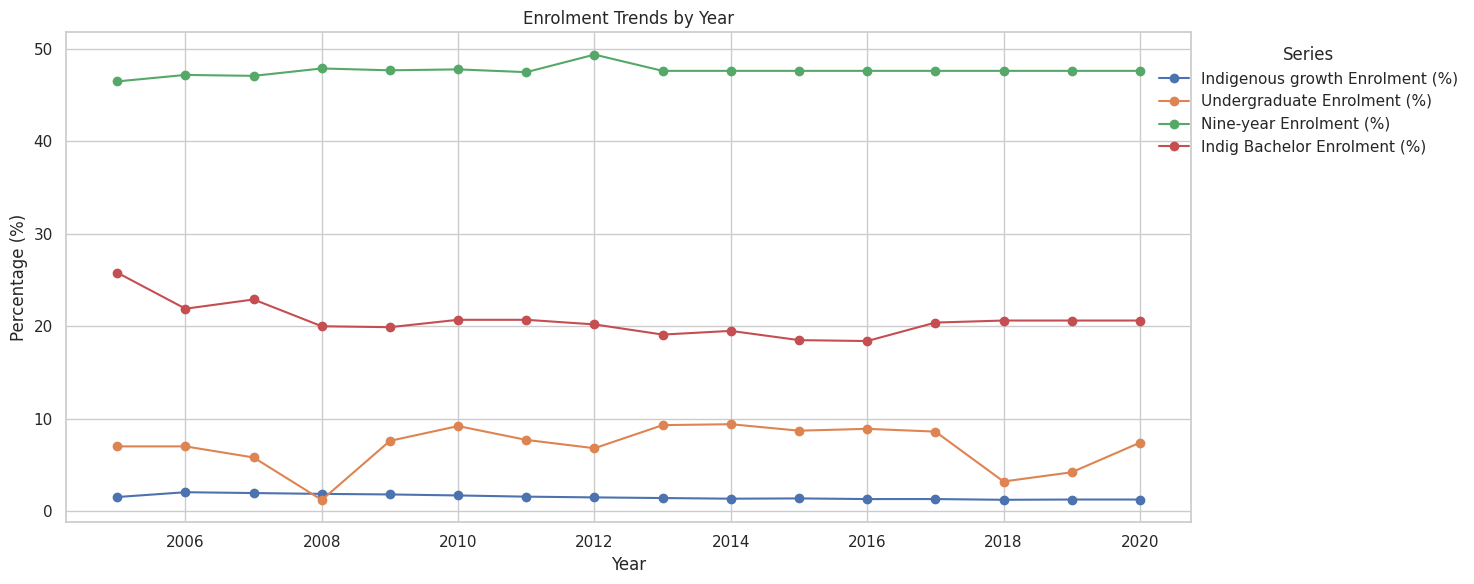

In [ ]:
final_df.set_index("Year").plot(
    kind="line", marker="o", figsize=(15, 6)
)
plt.title("Enrolment Trends by Year")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.legend(title="Series",bbox_to_anchor=(1.25, 1), loc="upper right", frameon=False)
plt.grid(True, alpha=1)
plt.tight_layout()
plt.show()


 **Insights**

 Providing a clear and concise summary of the main patterns, trends, or correlations discovered from the analysis

**Main Patterns**

**Indigenous Enrolment (%):**

Rose slightly from 1.52% in 2005 to around 1.25% in 2020.

After peaking in 2006 (2.04%), it declined gradually and stabilised near 1.2%.

**Undergraduate Enrolment (%):**

Showed greater volatility: a sharp dip in 2008 (1.2%), a strong recovery (9–9.4% in 2013–14), then a drop in 2018 (3.2%) before recovering to 7.4% in 2020.

**Nine-year Completion Enrolment (%):**

Remained the most stable indicator, holding between 46.5% and 49.4% across the whole period.

Suggests steady retention/completion rates despite enrolment fluctuations.

**Indigenous Bachelor Enrolment (%):**

Declined from 25.8% (2005) to a low of 18.4% (2016), then increased to about 20.6% (2017–20).

There has been steady growth in higher-level qualifications (Bachelor and Postgraduate), yet Indigenous participation at entry-level remains around 1–1.3% of total enrolments.

While completion rates have remained stable, attention may need to shift toward boosting initial enrolments and strengthening access pathways such as Enabling and Sub-bachelor programs.

The sharp rise in non-award and postgraduate enrolments highlights strong demand for lifelong learning. However, ensuring these pathways effectively lead into formal degree programs remains a critical priority.


# ***References***

Australia, U., 2020. Indigenous strategy annual report. Retrieved Sep, 11, p.2025.

Siami-Namini, S., Tavakoli, N. and Namin, A.S., 2018, December. A comparison of ARIMA and LSTM in forecasting time series. In 2018 17th IEEE international conference on machine learning and applications (ICMLA) (pp. 1394-1401). Ieee.

Report pdf  generation

In [ ]:
!jupyter nbconvert --to html /content/SIT742_Modern_Data_Science.ipynb

[NbConvertApp] Converting notebook /content/SIT742_Modern_Data_Science.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 35 image(s).
[NbConvertApp] Writing 8911642 bytes to /content/SIT742_Modern_Data_Science.html


In [ ]:
# !apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra

In [ ]:
#!apt-get update
#!apt-get install -y pandoc

In [ ]:
#!jupyter nbconvert --to pdf /content/SIT742_Modern_Data_Science.ipynb

In [ ]:
#!ls